# Deep Convolutional GAN - Ising model

In [1]:
%matplotlib inline

# basic libraries
import os, sys
import re
import copy
import glob
from itertools import product
import pickle
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [36]:
# local library
sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_ising
from statmechlib.preprocessing import Trajectory

In [20]:
sim_dir = '../src/mcsim/micro'
temps = ['t1', 't2', 't5', 't10', 't20', 't100']  # ferromagnetic
temps.extend(['a1', 'a2', 'a5', 'a10', 'a20', 'a100'])  # antiferromagnetic

# temps = ['t5']  # ferromagnetic
# temps.extend(['a5'])  # antiferromagnetic

In [21]:
trjs = {}
for t in temps:
    print(t)
    trjs[t] = read_lattice_ising(os.path.join(sim_dir, t))

trjs.keys()

t1
t2
t5
t10
t20
t100
a1
a2
a5
a10
a20
a100


dict_keys(['t1', 't2', 't5', 't10', 't20', 't100', 'a1', 'a2', 'a5', 'a10', 'a20', 'a100'])

In [23]:
cfgs = {}
cfgs_pad = {}
for key, trj in trjs.items():
    cfgs[key] = []
    cfgs_pad[key] = []
    for t_cfg, xyz_cfg in zip(trj['atom_type'], trj['xyz_latt']): 
        cfg = np.empty((4, 4), dtype=float)
        for t, (i, j, k) in zip(t_cfg, xyz_cfg):
            cfg[i-1, j-1] = 0.5*(t+1)
        cfgs[key].append(cfg)
        cfgs_pad[key].append(np.pad(cfg, pad_width=((1,1), (1,1)), mode='wrap'))

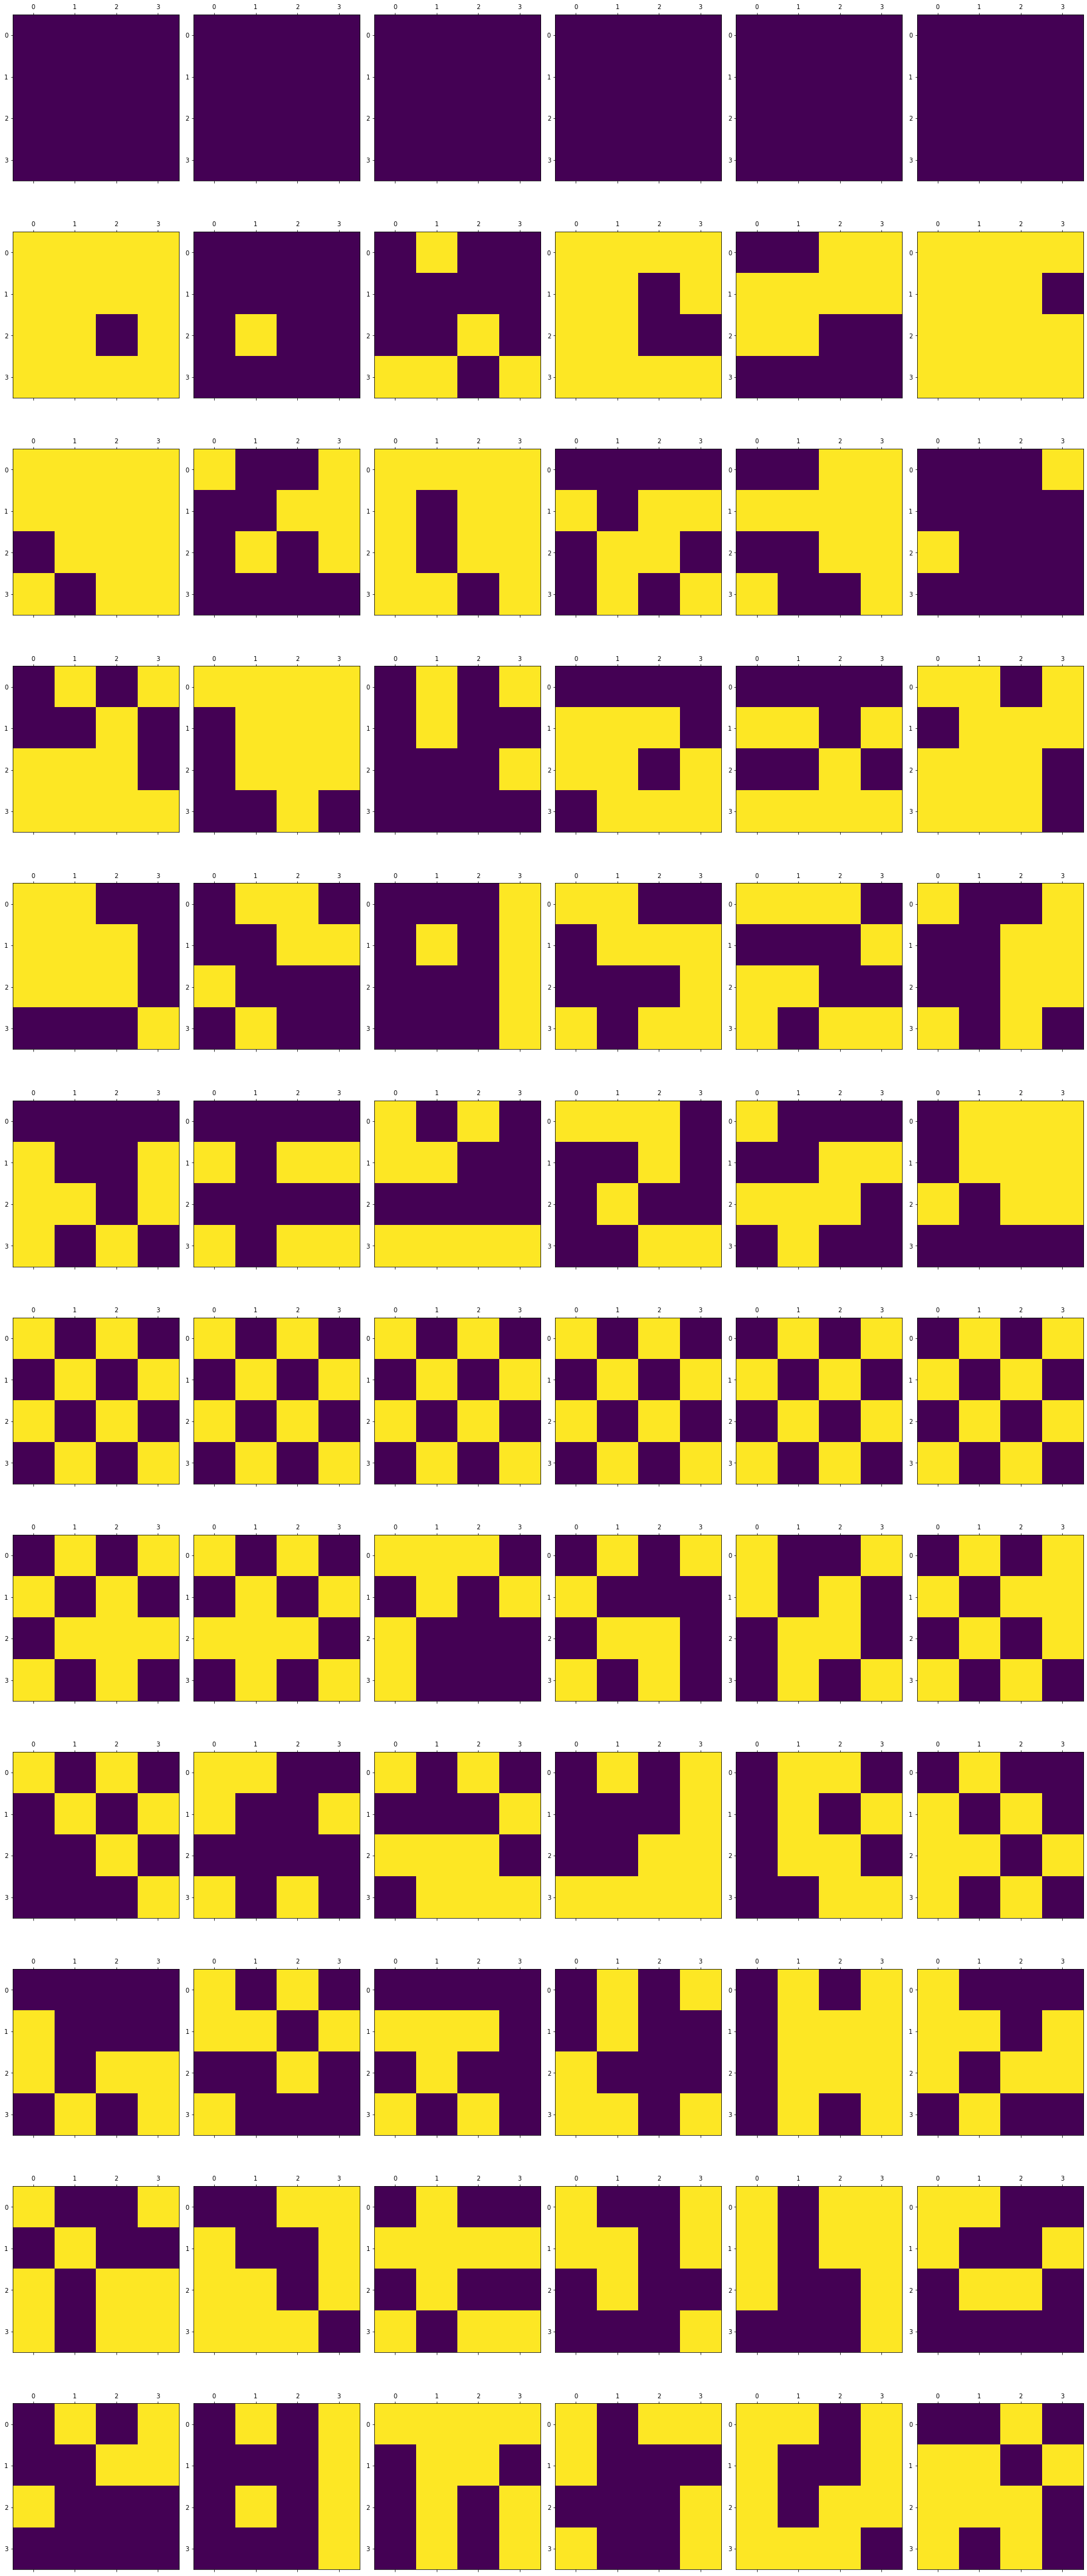

In [24]:
fig, axs = plt.subplots(nrows=len(temps), ncols=6, figsize=(25,5*len(temps)))
axs = axs.flatten()
for i, t in enumerate(temps):
    for j in range(6):
        k = 6*i + j
        axs[k].matshow(cfgs[t][j*100+10])

fig.tight_layout()

In [46]:
def write_xyz(filename, traj):
    with open(filename, 'w') as f:

        # cycle over configurations
        for t in range(len(traj['xyz_latt'])):
            
            nat = len(traj['atom_type'][t])
            f.write(f"{nat}\n")
            
            ene = traj['energy'][t]
            bx, by, bz = np.diag(traj['box_latt'][t])
            f.write(f"{round(ene, 6)} {bx} {by} {bz}\n")

            for i in range(nat):
                ti = traj['atom_type'][t][i]
                if ti < 0:
                    ti = 0
                x, y, z = traj['xyz_latt'][t][i]
#                 x = round(x + 0.5*bx, 6)
#                 y = round(y + 0.5*by, 6)
#                 z = round(z + 0.5*bz, 6)
                f.write(f"{ti} {x} {y} {z}\n")

In [51]:
trjs['a5']['energy'][100], trjs['t5']['energy'][100]

(-2.3999999999987467, -2.3999999999987467)

In [48]:
for sysname in ['t5', 'a5']:
    trj = Trajectory(trjs[sysname])
    traj_cut = trj[1:]
    write_xyz(os.path.join('../../../embed/sim', sysname + '.xyz'), traj_cut)

    #plt.hist(traj_cut['energy'], bins=20)

In [29]:
trjs['t5']['energy']#.keys()#['box_latt']

[-2.4,
 -4.800000000000017,
 4.884981308350689e-15,
 -2.3999999999999653,
 1.9539925233402755e-14,
 -4.799999999999944,
 -2.399999999999935,
 -4.799999999999935,
 -2.3999999999999475,
 5.1514348342607263e-14,
 -9.599999999999977,
 2.4000000000000186,
 -2.3999999999999746,
 4.1744385725905886e-14,
 -4.799999999999905,
 -2.399999999999898,
 1.1146639167236572e-13,
 1.212363542890671e-13,
 -4.799999999999848,
 -7.199999999999859,
 -4.799999999999871,
 -4.799999999999892,
 -9.59999999999988,
 -4.799999999999869,
 -2.3999999999999013,
 -4.799999999999892,
 1.4432899320127035e-13,
 -11.999999999999858,
 -4.799999999999833,
 -7.199999999999832,
 -7.199999999999767,
 -2.3999999999997703,
 -4.799999999999752,
 2.4000000000002744,
 -4.799999999999718,
 -4.799999999999674,
 -2.399999999999681,
 -4.7999999999997,
 3.241851231905457e-13,
 -4.799999999999637,
 -4.7999999999996135,
 -7.199999999999582,
 -4.7999999999995815,
 -2.3999999999995834,
 -7.199999999999572,
 -4.799999999999608,
 -2.399999999

In [ ]:
write_xyz(os.path.join(sim_dir, 'ferro_5.xyz'), trjs['t5'])

In [183]:
img_rows = 15
img_cols = 15
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 9

## Generator

In [184]:
def sample(x):
    prediction = 0.5*(K.sign(x*2 -1) + 1)
    return prediction    

In [538]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(1 * 3 * 3, input_dim=z_dim))
    model.add(Reshape((3, 3, 1)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(8, kernel_size=3, strides=2, padding='valid'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='valid'))

#     # Batch normalization
#     model.add(BatchNormalization())

#     # Leaky ReLU activation
#     model.add(LeakyReLU(alpha=0.01))

#     # Transposed convolution layer, from 14x14x64 to 16x16x1 tensor
#     model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='valid'))

    # Output layer with tanh activation
    model.add(Activation('sigmoid'))
    
    #model.add(Lambda(sample))

    return model

## Discriminator

In [239]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 15x15x1 into 7x7x8 tensor
    model.add(
        Conv2D(8,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='valid'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x8 into 3x3x1 tensor
    model.add(
        Conv2D(1,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='valid'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## Build the Model

In [240]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [241]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [242]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 9)                 90        
_________________________________________________________________
reshape_22 (Reshape)         (None, 3, 3, 1)           0         
_________________________________________________________________
conv2d_transpose_43 (Conv2DT (None, 7, 7, 8)           80        
_________________________________________________________________
batch_normalization_44 (Batc (None, 7, 7, 8)           32        
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_transpose_44 (Conv2DT (None, 15, 15, 1)         73        
_________________________________________________________________
activation_22 (Activation)   (None, 15, 15, 1)         0         
Total para

In [295]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 7, 7, 8)           80        
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 3, 3, 1)           73        
_________________________________________________________________
batch_normalization_43 (Batc (None, 3, 3, 1)           4         
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 3, 3, 1)           0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 9)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 10        
Total para

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [296]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_58 (Sequential)   (None, 15, 15, 1)         275       
_________________________________________________________________
sequential_57 (Sequential)   (None, 1)                 167       
Total params: 442
Trainable params: 259
Non-trainable params: 183
_________________________________________________________________


## Training

In [346]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(target_data, iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    #(X_train, _), (_, _) = mnist.load_data()
    X_train = target_data
#    print(X_train.shape, type(X_train))
#     return
    # Load simulation data

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    #X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 9))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 9))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration, d_loss, 100.0 * accuracy, g_loss))
            print(np.sum(gen_imgs[5]))
            print(gen_imgs[0,0,:].flatten())
            print(imgs[0,0,:].flatten())

            # Output a sample of generated image
            sample_images(generator)

In [254]:
def sample_images(generator, image_grid_rows=2, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    #gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(8, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the Model and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

In [362]:
target_data = np.array(cfgs['a1'][-768:])
target_data.shape

(768, 15, 15)

0 [D loss: 0.377668, acc.: 87.50%] [G loss: 1.777174]
91.8067
[1.23547604e-11 1.96089409e-02 7.96783836e-14 2.13397387e-03
 9.67360616e-01 2.48448011e-02 4.19199407e-01 1.21491721e-04
 1.00000000e+00 9.88477349e-01 2.15933468e-07 9.12605600e-08
 1.77979714e-16 9.32573312e-06 5.01538754e-15]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.]
200 [D loss: 0.478168, acc.: 86.72%] [G loss: 2.241600]
68.15492
[1.9705578e-14 2.9737527e-07 5.9300616e-27 1.2247536e-15 9.9936813e-01
 9.9990845e-01 1.9618076e-01 3.1555814e-07 1.0000000e+00 7.8886271e-15
 1.0000000e+00 6.5627503e-09 1.5014057e-09 8.0320079e-16 8.6244028e-20]
[0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
400 [D loss: 0.376763, acc.: 90.62%] [G loss: 2.303414]
59.356754
[9.9999809e-01 1.8132840e-07 9.8089522e-01 1.2527287e-06 3.8928043e-17
 3.7381658e-09 3.5141056e-25 1.1139792e-08 1.4496425e-05 2.0870962e-03
 3.1802742e-04 4.9764362e-06 3.9879087e-14 1.4041397e-10 3.1417240e-11]
[1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
600 [D l

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


4200 [D loss: 0.648935, acc.: 70.31%] [G loss: 1.538443]
124.821365
[9.8600024e-01 2.5411478e-10 7.4263867e-03 1.0839568e-11 1.5784857e-04
 1.4303651e-14 3.1581916e-07 3.8502953e-04 2.0517779e-10 1.9585782e-04
 2.0491623e-07 5.0865268e-10 1.1818042e-06 2.3402860e-15 6.5625216e-05]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.]
4400 [D loss: 0.627162, acc.: 75.00%] [G loss: 1.619281]
118.851074
[7.4881691e-01 3.3452701e-09 3.8722059e-04 6.5468880e-12 3.4138509e-05
 9.9880624e-01 1.1775333e-07 3.1075271e-11 1.1844818e-06 1.0000000e+00
 1.7243290e-15 2.2680151e-11 4.7721029e-03 1.8068655e-17 3.8101804e-02]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
4600 [D loss: 0.556663, acc.: 71.09%] [G loss: 1.416533]
112.68089
[1.0000000e+00 4.0015331e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 1.0000000e+00 1.6503732e-11 2.6868334e-01 3.6832831e-26
 9.9999774e-01 4.1731357e-10 1.6423117e-04 4.0465331e-17 7.0272990e-02]
[0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
4800 [D loss: 

9200 [D loss: 0.616873, acc.: 65.62%] [G loss: 0.877750]
107.23391
[1.8464505e-07 9.9999869e-01 4.7399301e-23 9.6875966e-01 1.9455611e-22
 9.9967372e-01 3.3014738e-10 2.6261682e-09 1.1630420e-04 6.2623408e-20
 1.0000000e+00 1.8024109e-14 9.9770325e-01 3.3217572e-13 9.9878126e-01]
[0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.]
9400 [D loss: 0.622914, acc.: 60.94%] [G loss: 0.920211]
119.392296
[1.1853725e-08 9.9983716e-01 2.1545765e-21 9.9250996e-01 1.1916954e-07
 8.0350515e-21 1.0000000e+00 1.3686614e-34 1.0000000e+00 0.0000000e+00
 1.0000000e+00 3.3352467e-25 1.0000000e+00 6.0095443e-25 1.0000000e+00]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.]
9600 [D loss: 0.591226, acc.: 69.53%] [G loss: 0.945855]
104.73183
[6.2712598e-07 1.0000000e+00 4.0141727e-23 8.9767396e-01 2.3485923e-24
 1.0000000e+00 1.5620183e-25 4.1358336e-03 1.4386255e-25 9.8630977e-01
 9.6429841e-13 2.0327138e-11 1.8526107e-04 6.7882178e-10 2.9850248e-03]
[1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
9800 [D loss: 0

14200 [D loss: 0.646763, acc.: 63.28%] [G loss: 0.796258]
110.998276
[5.58327496e-01 5.77715814e-01 3.44505424e-09 2.25469889e-03
 7.87239074e-08 7.44410622e-09 1.00000000e+00 1.10463975e-27
 2.70418365e-16 1.00000000e+00 3.96054697e-35 8.34913492e-01
 5.46556762e-21 1.00000000e+00 7.97430751e-16]
[1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
14400 [D loss: 0.661954, acc.: 61.72%] [G loss: 0.783643]
115.47481
[4.3631294e-09 9.9972314e-01 1.1871109e-18 2.6837155e-01 1.4159495e-13
 9.9999988e-01 3.6216070e-09 3.8043395e-06 1.0000000e+00 5.0713116e-31
 1.0000000e+00 2.7133094e-11 1.0000000e+00 4.6141023e-23 1.0000000e+00]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.]
14600 [D loss: 0.697568, acc.: 50.78%] [G loss: 0.794920]
108.56378
[1.6679994e-08 9.9980086e-01 1.4526433e-18 7.5446099e-01 7.7468829e-23
 9.9999416e-01 8.3667035e-15 7.2520500e-13 6.0742236e-15 1.0000000e+00
 1.1786883e-22 7.1142304e-01 3.0687237e-11 3.7539303e-06 5.4544421e-06]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 

19200 [D loss: 0.667932, acc.: 52.34%] [G loss: 0.816197]
105.9578
[9.7878426e-02 3.3973563e-02 4.0438313e-06 2.6884547e-02 1.2396114e-15
 1.0715240e-08 8.2701220e-20 9.7095639e-01 1.6187686e-24 9.9997079e-01
 6.8683394e-14 3.7284306e-01 6.7044470e-15 1.9377229e-09 1.9188717e-07]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0.]
19400 [D loss: 0.675735, acc.: 58.59%] [G loss: 0.816743]
113.21492
[7.8554061e-17 9.5669448e-01 0.0000000e+00 4.4082437e-08 2.9871089e-32
 1.0000000e+00 3.2081321e-20 8.7618452e-01 9.8915195e-01 7.6249242e-21
 1.0000000e+00 2.9239049e-11 1.0000000e+00 3.1794104e-31 1.0000000e+00]
[0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.]
19600 [D loss: 0.685363, acc.: 57.03%] [G loss: 0.771948]
114.25809
[9.6680450e-01 9.9101287e-01 1.0000000e+00 3.3599895e-07 5.0810324e-03
 7.9735083e-18 7.3588393e-24 3.5846610e-09 0.0000000e+00 1.0000000e+00
 3.0730381e-35 9.9996614e-01 1.3350061e-24 8.7795424e-01 4.3352768e-15]
[1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
19800 [D loss:

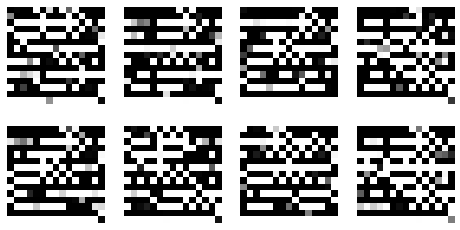

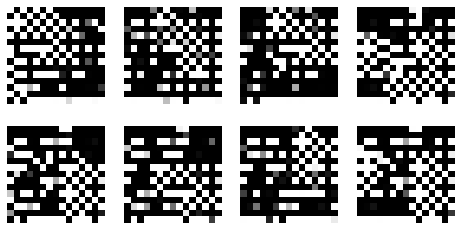

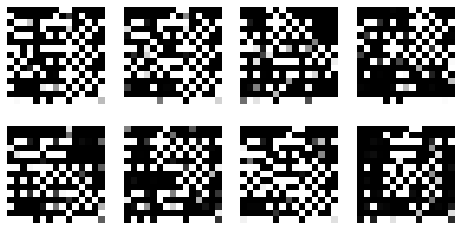

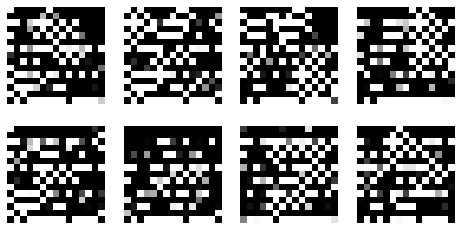

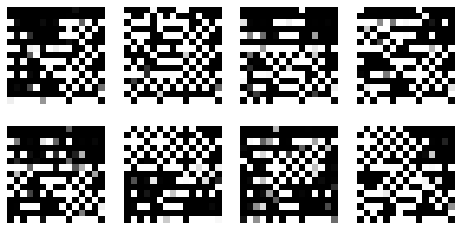

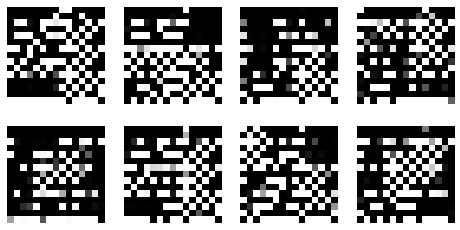

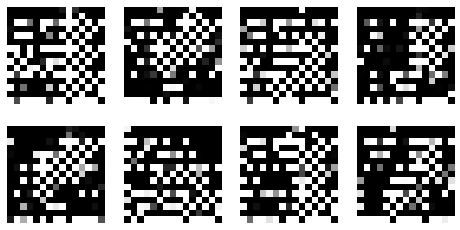

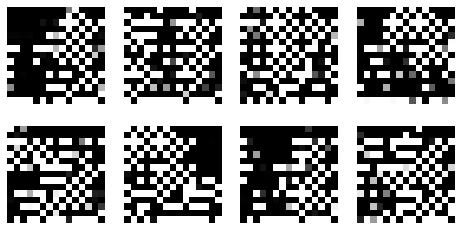

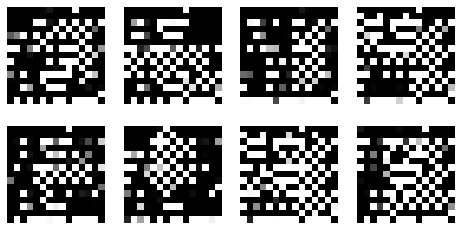

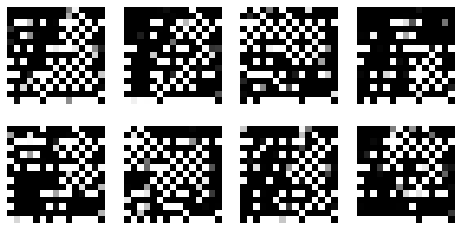

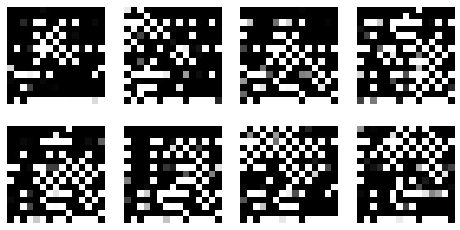

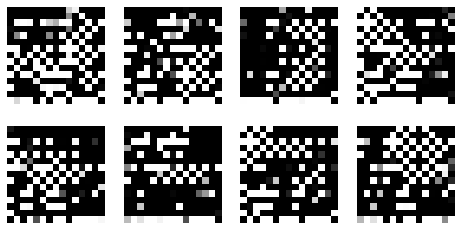

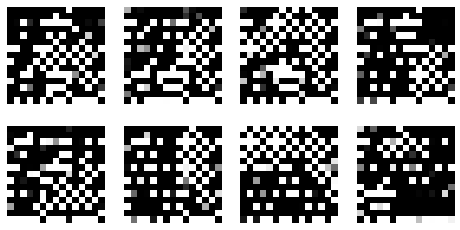

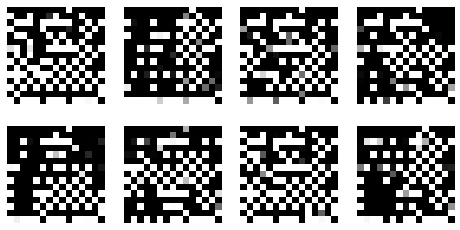

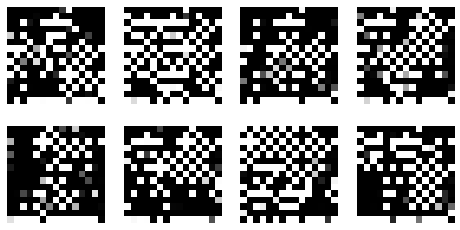

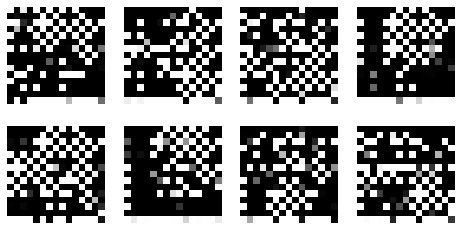

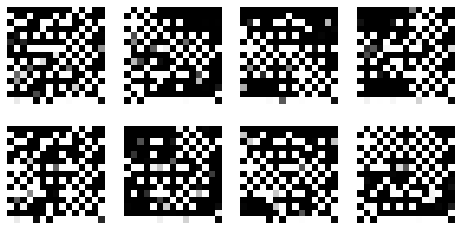

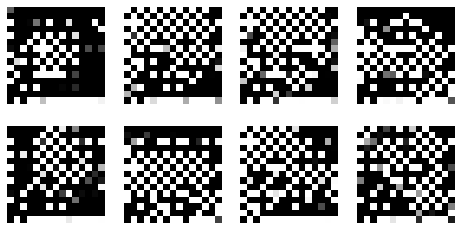

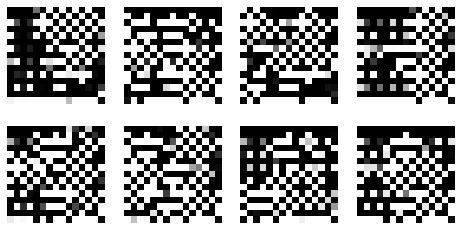

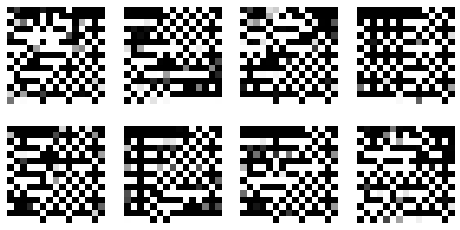

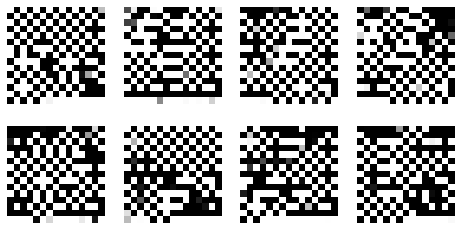

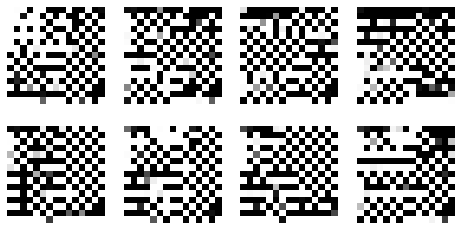

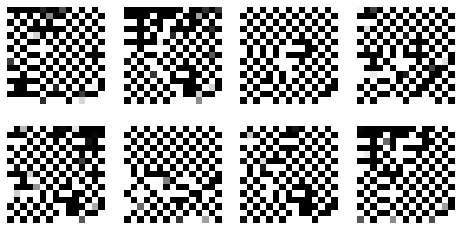

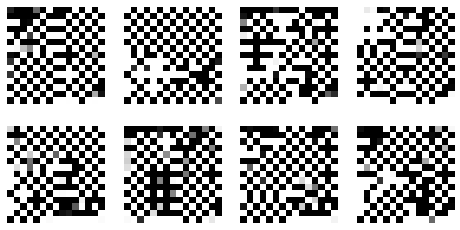

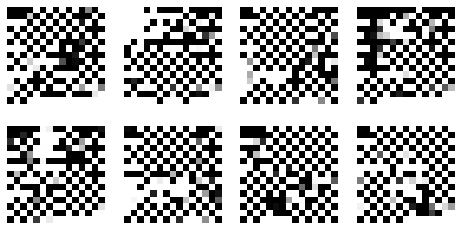

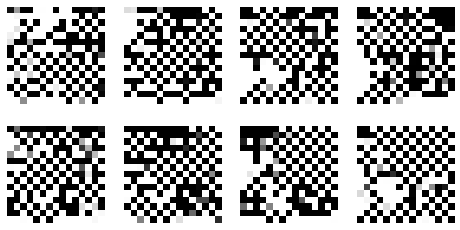

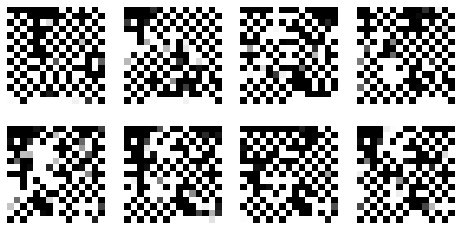

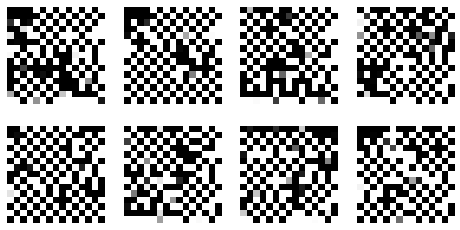

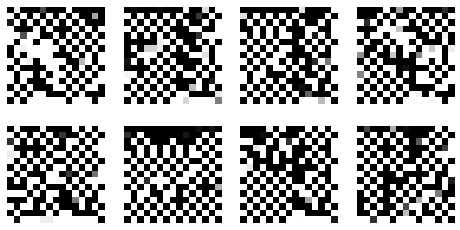

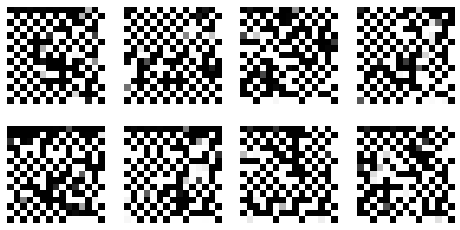

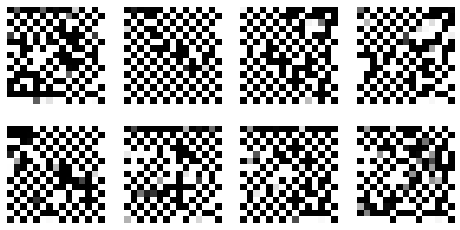

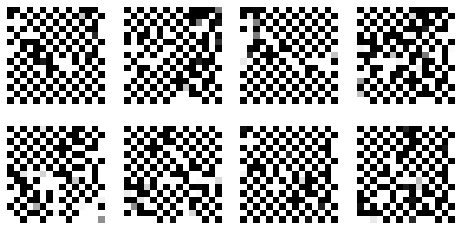

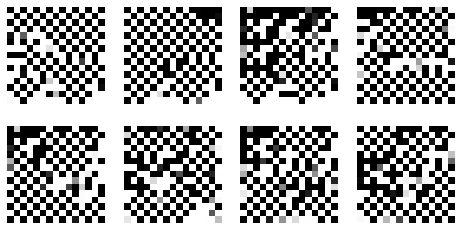

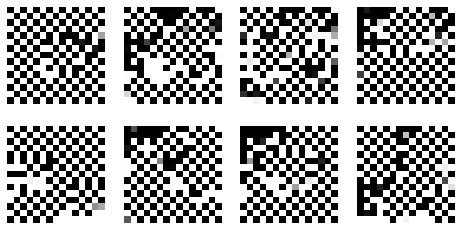

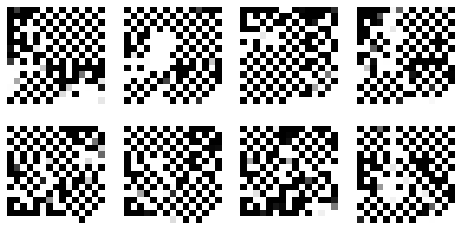

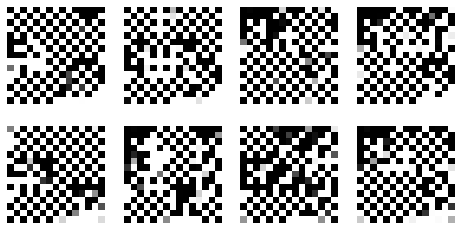

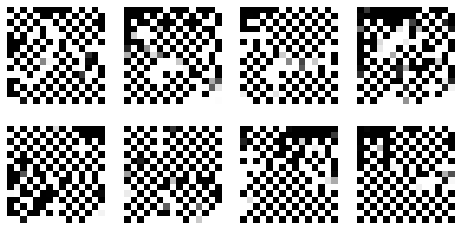

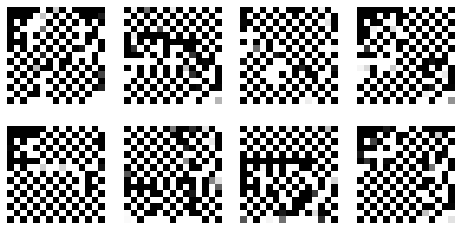

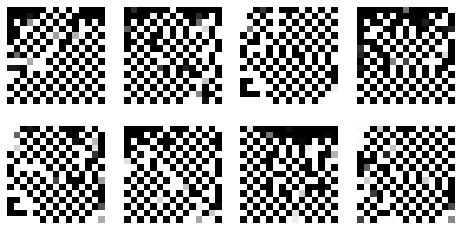

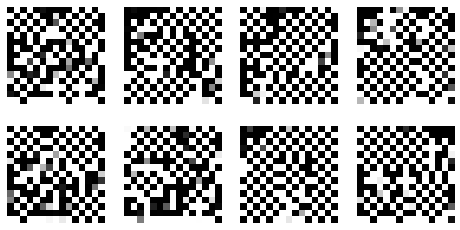

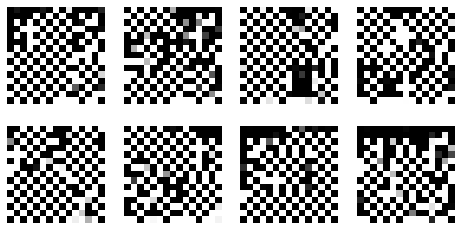

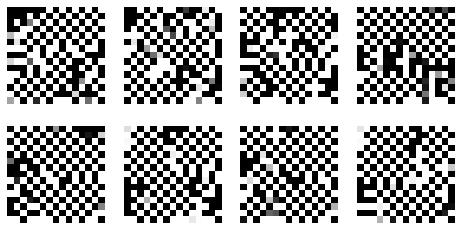

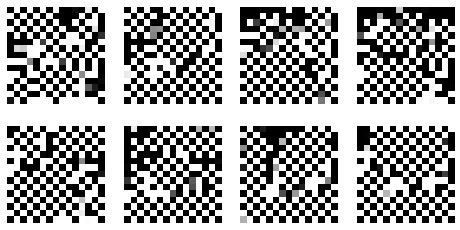

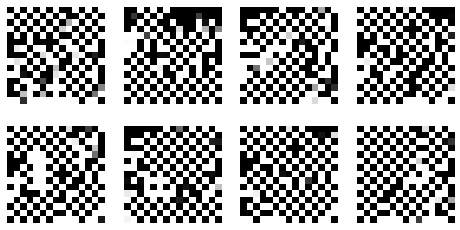

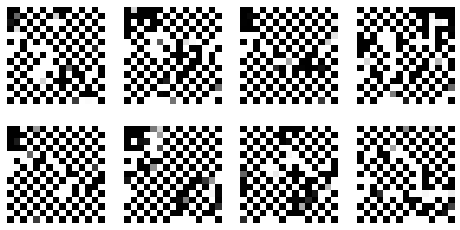

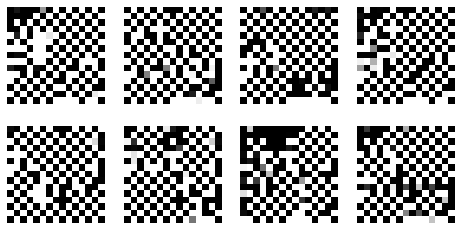

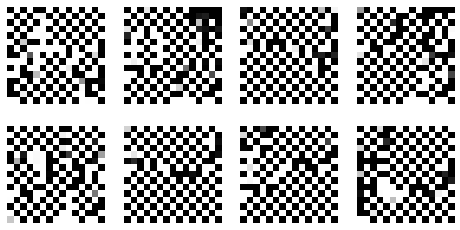

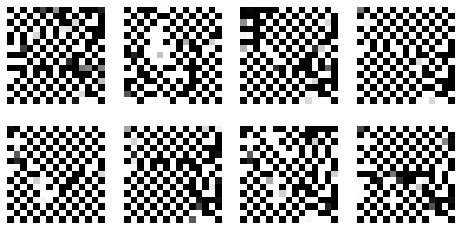

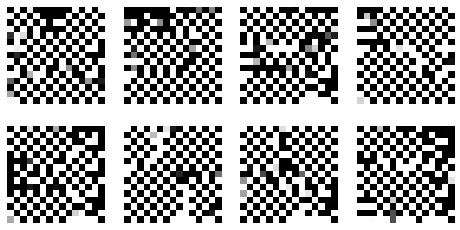

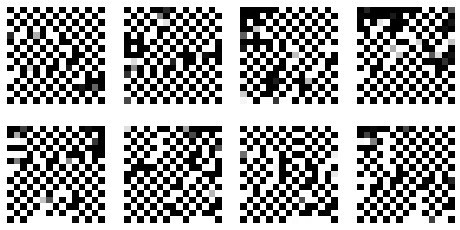

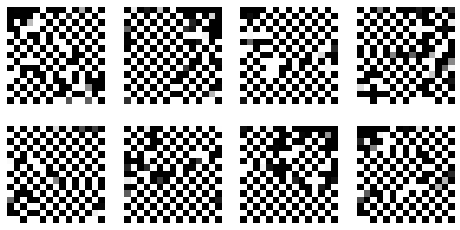

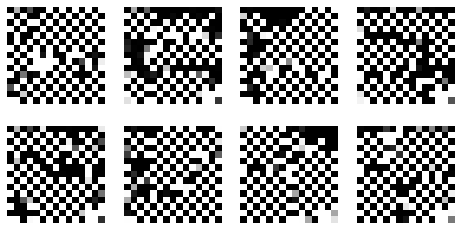

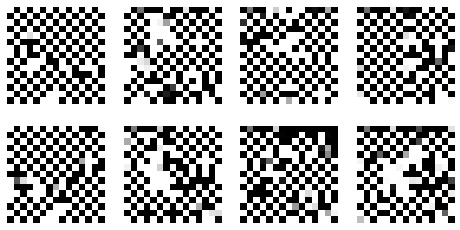

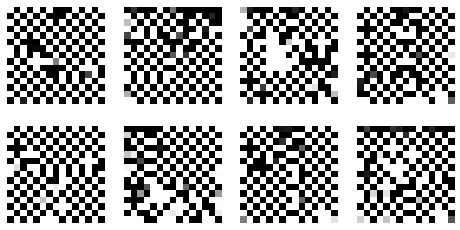

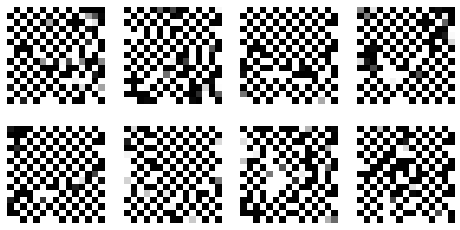

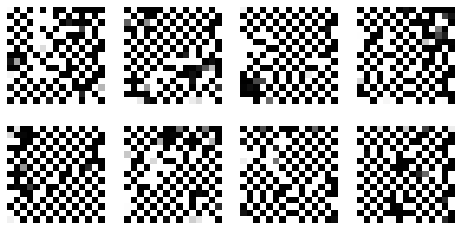

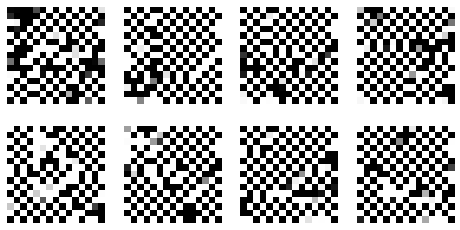

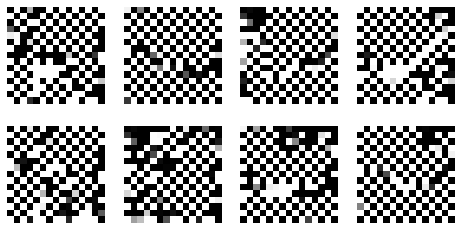

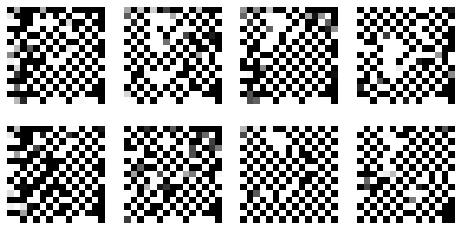

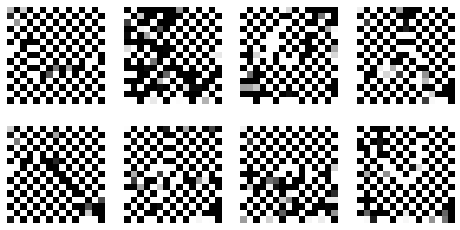

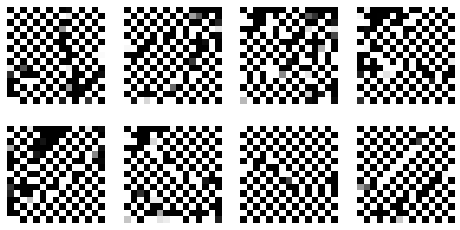

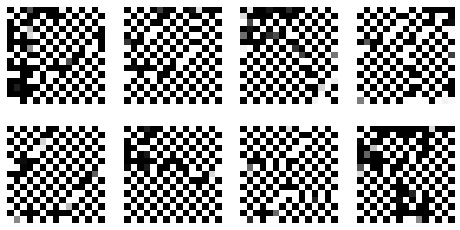

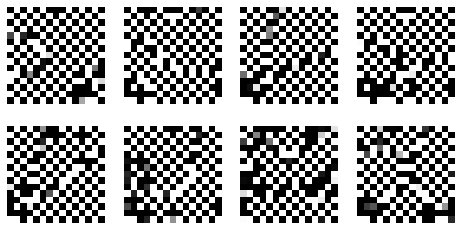

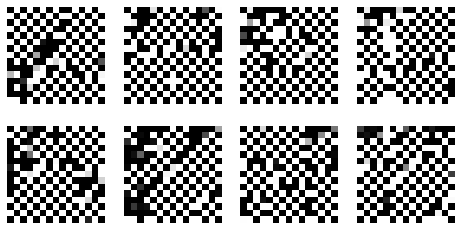

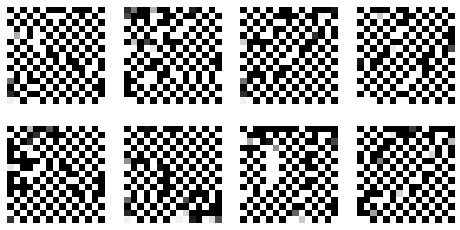

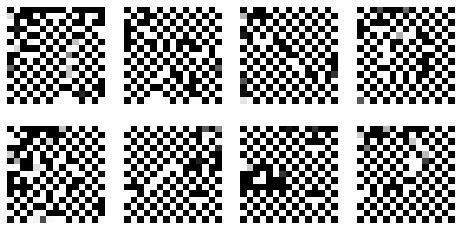

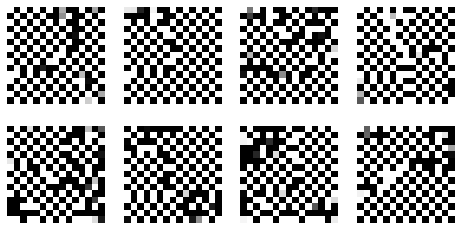

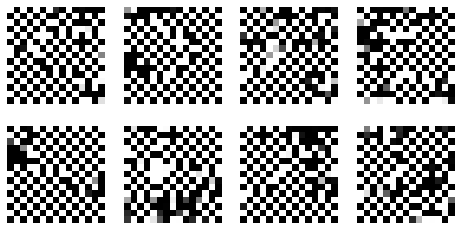

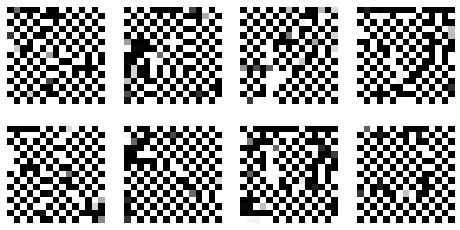

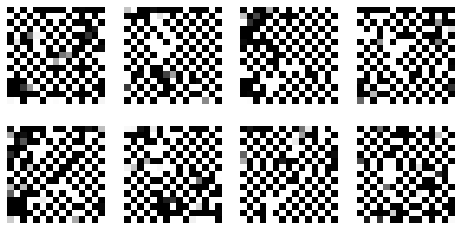

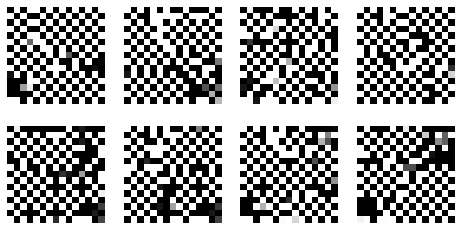

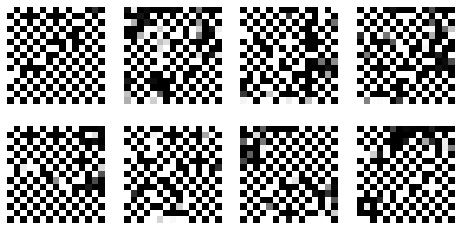

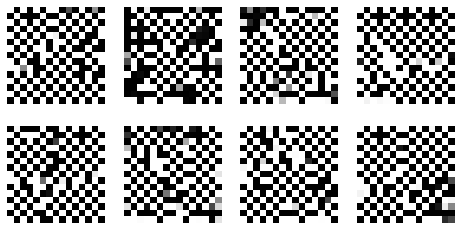

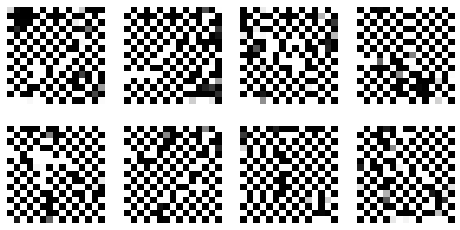

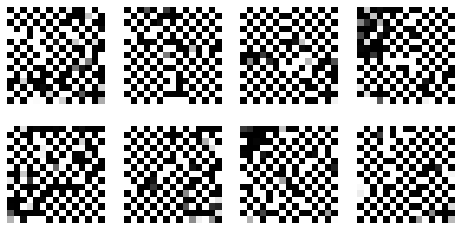

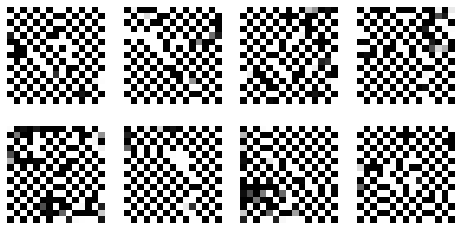

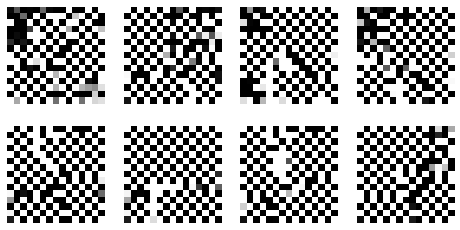

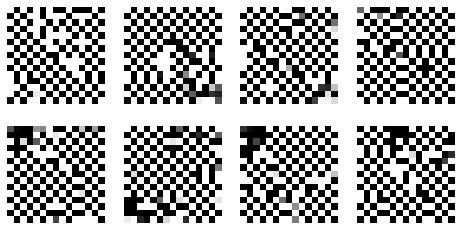

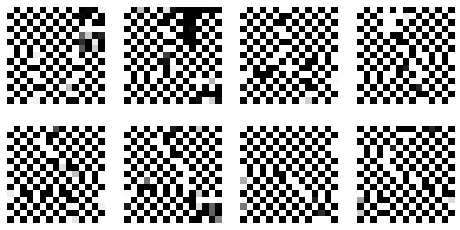

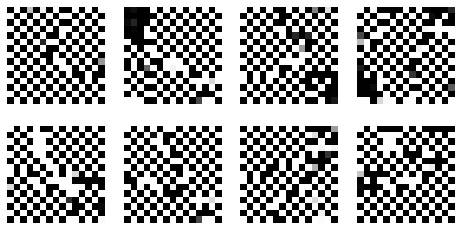

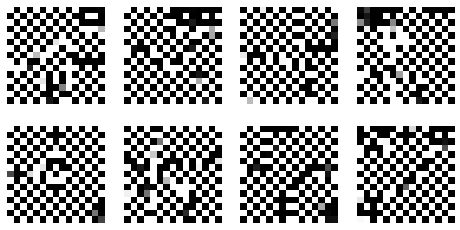

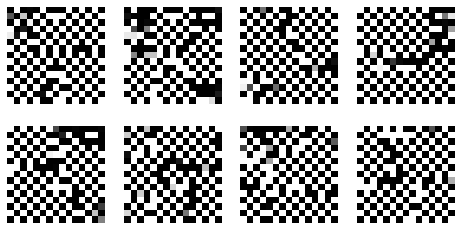

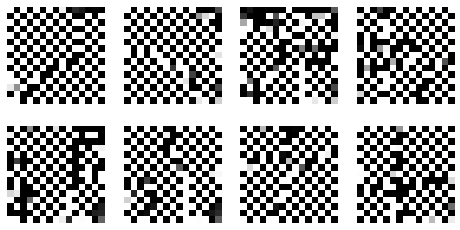

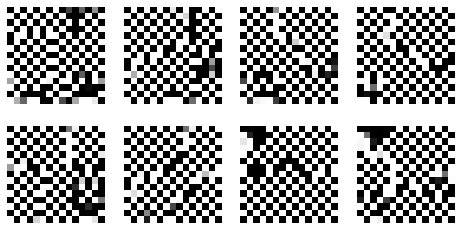

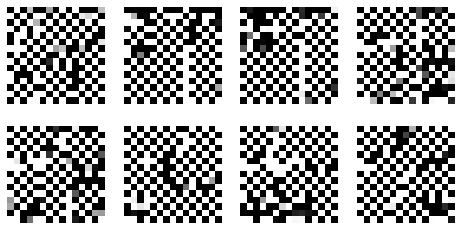

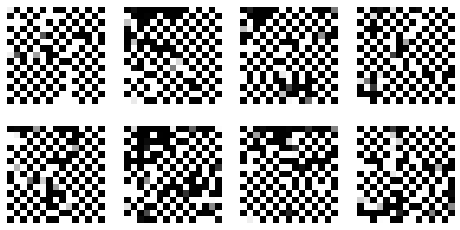

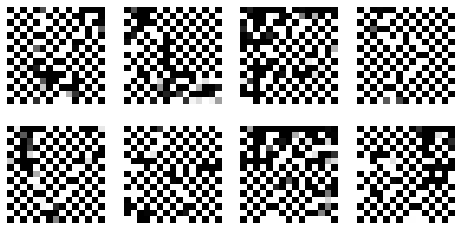

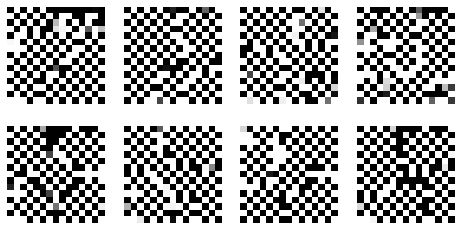

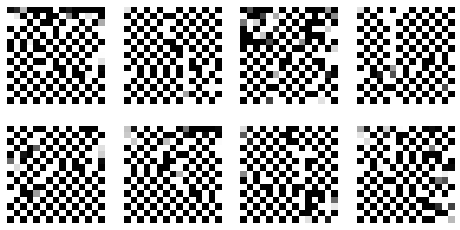

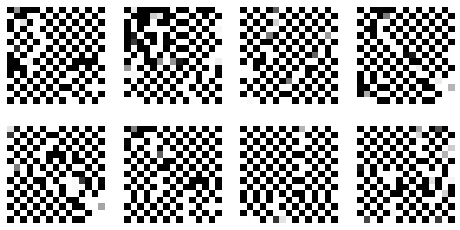

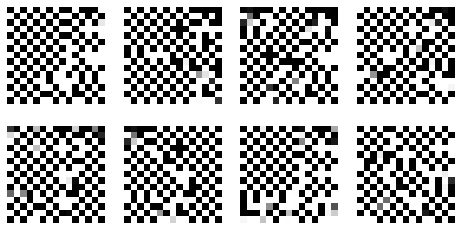

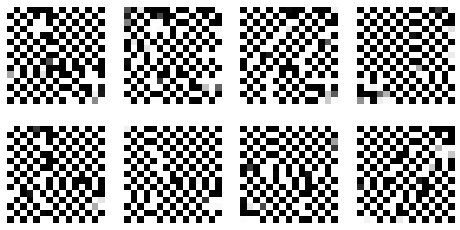

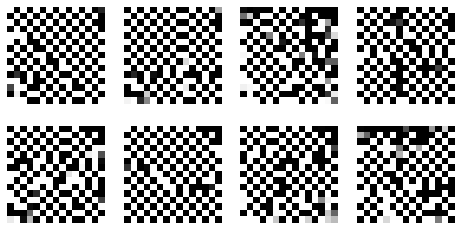

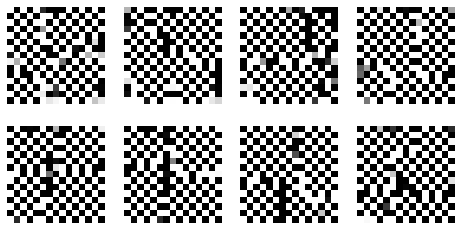

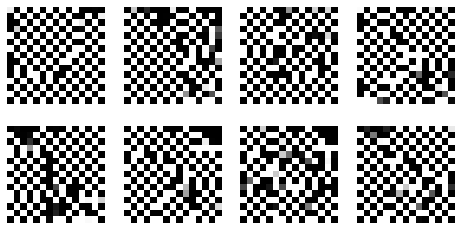

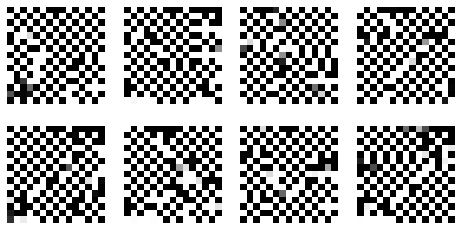

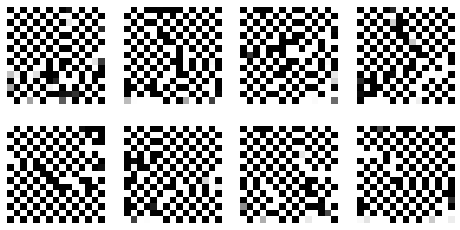

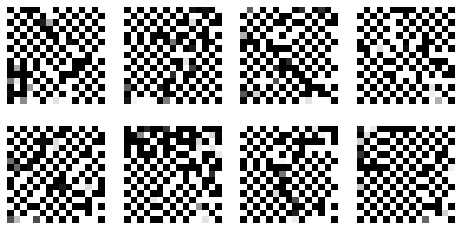

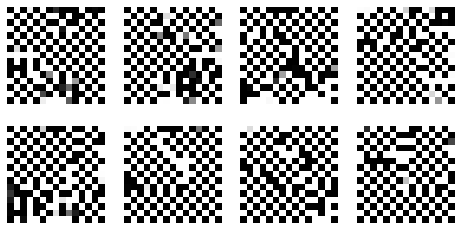

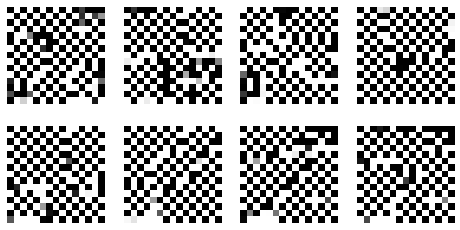

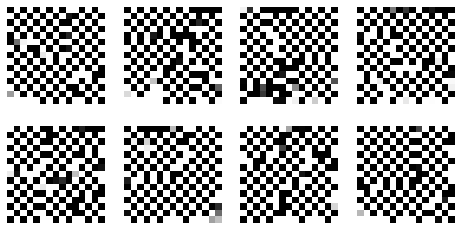

In [363]:
# Set hyperparameters
iterations = 20001
batch_size = 64
sample_interval = 200

# Train the DCGAN for the specified number of iterations
train(target_data, iterations, batch_size, sample_interval)

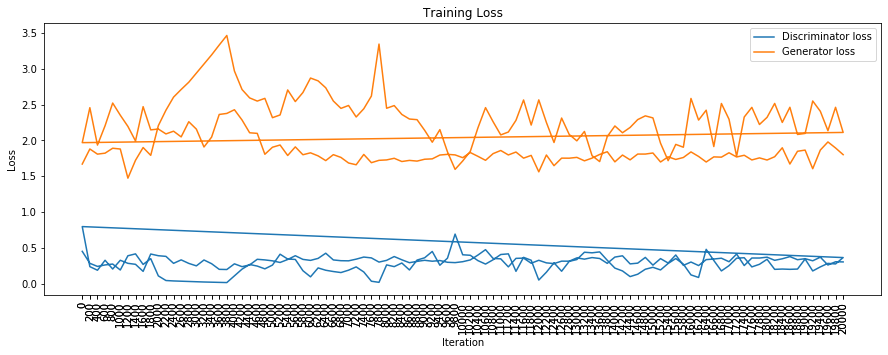

In [361]:
losses_x = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses_x.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses_x.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

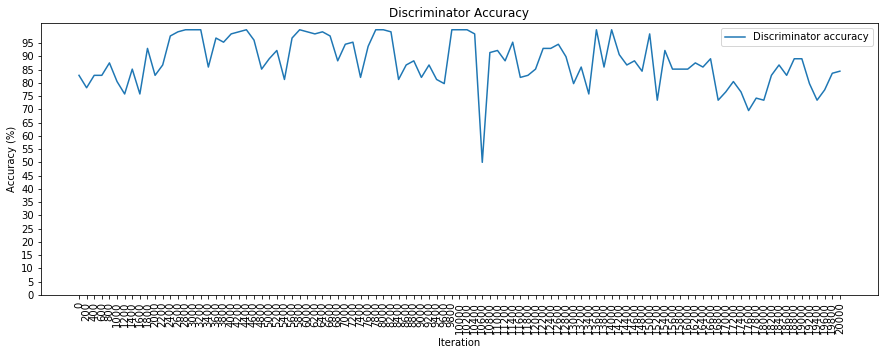

In [345]:
accuracies_x = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies_x, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

## Visualize filters

In [365]:
layer_name = 'conv2d_43'
filter_index = 0

layer_output = discriminator.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [366]:
discriminator.get_input_at(1)

<tf.Tensor 'sequential_58/activation_22/Sigmoid:0' shape=(?, ?, ?, 1) dtype=float32>

In [367]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, discriminator.get_input_at(0))[0]

In [368]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [369]:
iterate = K.function([discriminator.get_input_at(0)], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 15, 15, 1))])

In [370]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 15, 15, 1))

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [371]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [372]:
def generate_pattern(layer_name, filter_index, size=15):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = discriminator.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, discriminator.get_input_at(0))[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([discriminator.get_input_at(0)], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 1))

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return img #deprocess_image(img)

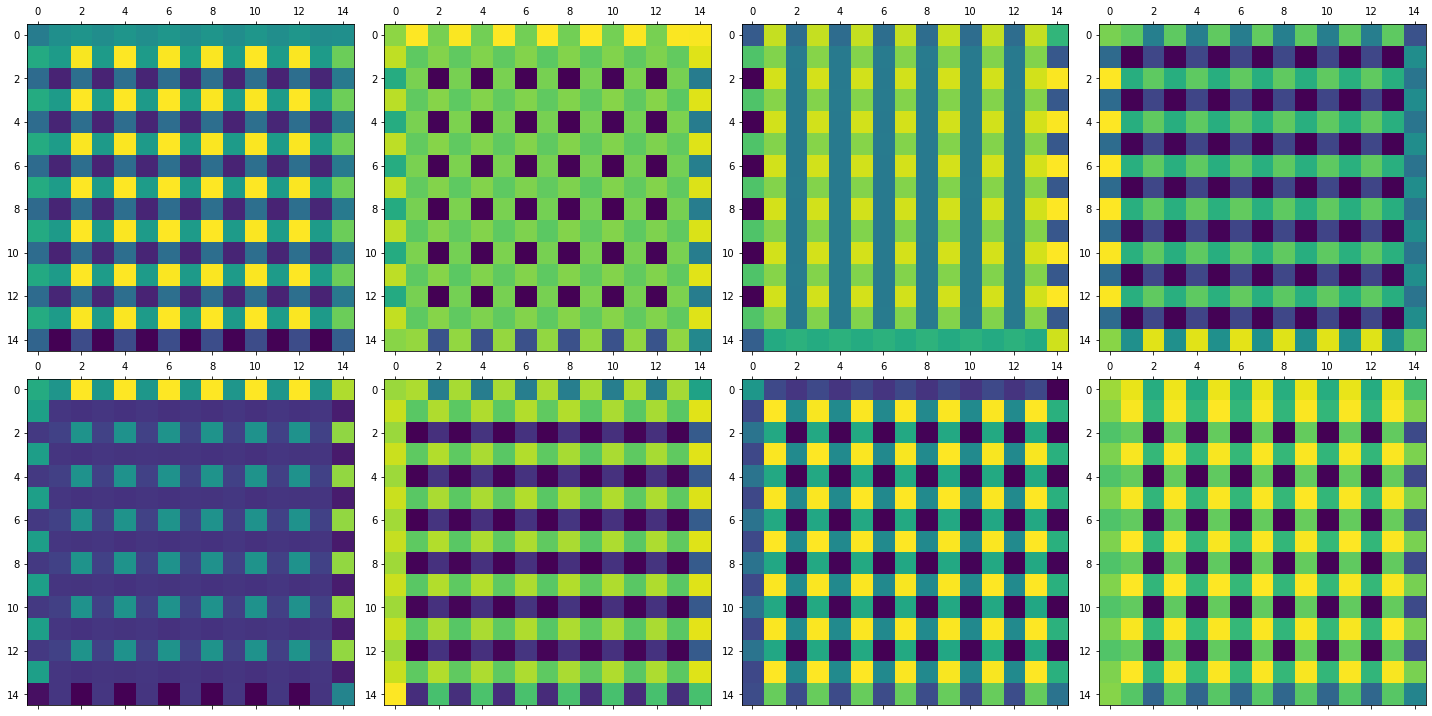

In [373]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(8):
    axs[i].matshow(generate_pattern('conv2d_43', i)[:,:,0])

fig.tight_layout()

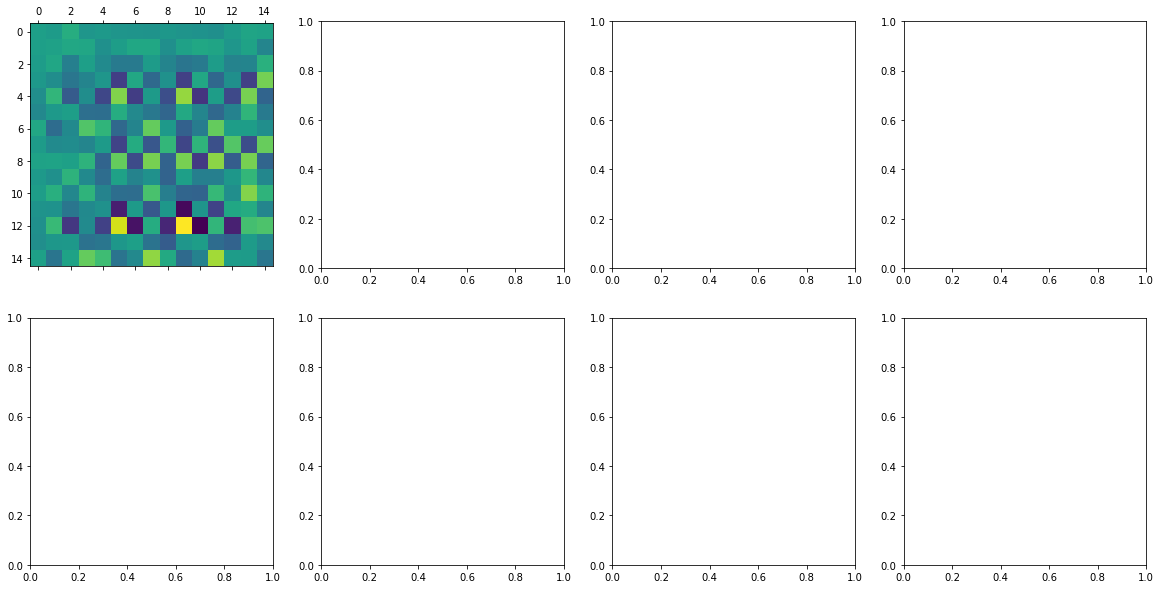

In [374]:
xfig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(1):
    axs[i].matshow(generate_pattern('conv2d_44', i, size=15)[:,:,0])

fig.tight_layout()

In [342]:
target_data = np.array(cfgs['t2'][-768:])
target_data.shape

(768, 15, 15)

0 [D loss: 0.452058, acc.: 81.25%] [G loss: 1.670281]
112.96371
[6.7647089e-17 1.0000000e+00 1.3040328e-05 6.7200977e-04 4.9392962e-27
 1.0000000e+00 1.1377362e-21 5.9301255e-04 4.5742694e-22 1.0000000e+00
 1.4548741e-16 9.7112992e-05 4.7595230e-09 4.2283401e-01 8.2621781e-08]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
200 [D loss: 0.285016, acc.: 90.62%] [G loss: 1.880598]
112.05393
[9.8707759e-01 1.3248435e-05 9.9630260e-01 4.4498927e-04 1.0000000e+00
 1.8584441e-11 6.2827436e-15 9.9941826e-01 1.6784995e-08 7.4366731e-08
 9.8619139e-01 7.3339214e-04 9.9695587e-01 3.5713729e-05 9.9511212e-01]
[1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
400 [D loss: 0.241794, acc.: 89.84%] [G loss: 1.808769]
116.93167
[2.8208694e-10 9.9989414e-01 7.3538482e-01 1.1189361e-09 1.0000000e+00
 3.2430131e-10 8.8867246e-08 9.9985838e-01 1.8482411e-16 9.9997485e-01
 9.9996638e-01 2.0922679e-08 9.9791723e-01 2.6781810e-03 8.5479589e-03]
[1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
600 [D loss: 0.262261

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


4200 [D loss: 0.203670, acc.: 93.75%] [G loss: 2.710618]
121.365814
[1.6417761e-12 1.0000000e+00 7.4752113e-16 1.0000000e+00 1.1658770e-21
 1.0000000e+00 1.3619364e-28 1.0000000e+00 3.6950879e-20 1.0000000e+00
 6.5829924e-18 1.0000000e+00 5.6305649e-05 1.0000000e+00 3.8752583e-04]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
4400 [D loss: 0.268753, acc.: 92.19%] [G loss: 2.593673]
119.38223
[2.4471983e-05 9.9953747e-01 1.6726399e-05 9.9998796e-01 9.9379247e-01
 8.7743634e-01 9.9555463e-01 9.5881736e-01 1.3626089e-10 1.7890381e-02
 2.3108823e-05 1.0000000e+00 1.7873114e-09 1.0000000e+00 5.0819153e-08]
[0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
4600 [D loss: 0.246434, acc.: 90.62%] [G loss: 2.549371]
123.65082
[3.7576064e-11 1.0000000e+00 2.5244279e-14 1.0000000e+00 1.7156462e-10
 9.9999988e-01 9.8635441e-01 9.6807307e-01 9.8548935e-06 1.2233185e-10
 5.6494353e-12 9.9989557e-01 4.3030680e-14 4.8685947e-12 7.0583136e-12]
[0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
4800 [D loss: 0

9200 [D loss: 0.450452, acc.: 78.91%] [G loss: 1.975132]
112.90873
[4.7013757e-01 2.0452391e-03 9.9586833e-01 2.4991862e-03 9.9997997e-01
 7.5450507e-10 9.9999940e-01 1.7992942e-08 1.3488918e-04 9.7157896e-01
 3.7907869e-10 1.0000000e+00 5.4665647e-15 1.0000000e+00 2.8261461e-22]
[0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.]
9400 [D loss: 0.258412, acc.: 89.84%] [G loss: 2.150702]
109.217575
[3.7669054e-06 9.9997437e-01 1.1177505e-05 1.0000000e+00 1.3447114e-10
 1.0000000e+00 6.0703789e-15 9.9649823e-01 7.4314755e-07 1.0000000e+00
 8.8344061e-11 1.0000000e+00 1.8746638e-06 1.0000000e+00 2.8349473e-10]
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]
9600 [D loss: 0.357032, acc.: 82.03%] [G loss: 1.840095]
108.046646
[1.8779347e-03 4.5222241e-01 9.3433446e-01 1.0000000e+00 8.7691444e-07
 9.9999917e-01 3.5779962e-08 2.5253071e-08 5.2791848e-03 2.8287561e-04
 4.6356527e-07 9.9998736e-01 1.6534147e-03 9.9876803e-01 9.6726336e-04]
[1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
9800 [D loss: 

14200 [D loss: 0.178533, acc.: 94.53%] [G loss: 2.107237]
105.895294
[8.8239455e-01 9.9999821e-01 9.9999988e-01 6.7188358e-01 1.0000000e+00
 1.0000000e+00 5.0326274e-11 7.2652262e-01 0.0000000e+00 1.0000000e+00
 0.0000000e+00 8.9396060e-01 3.3501888e-19 9.9999154e-01 2.1279946e-12]
[1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.]
14400 [D loss: 0.099646, acc.: 97.66%] [G loss: 2.181324]
115.6787
[8.4141415e-01 9.4813293e-01 1.0000000e+00 9.9443734e-01 1.0000000e+00
 1.0000000e+00 1.0000000e+00 9.5928425e-01 1.5815785e-05 9.9704725e-01
 1.3834630e-13 9.9901545e-01 1.8398928e-14 9.9995542e-01 8.5549312e-10]
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
14600 [D loss: 0.132644, acc.: 97.66%] [G loss: 2.290827]
127.36677
[1.08266884e-16 9.54860006e-04 0.00000000e+00 9.99905825e-01
 0.00000000e+00 1.00000000e+00 0.00000000e+00 9.99773920e-01
 2.57168615e-21 1.00000000e+00 9.87684488e-01 9.61836278e-01
 9.99999762e-01 1.00000000e+00 9.99999523e-01]
[1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0

19200 [D loss: 0.178326, acc.: 92.97%] [G loss: 2.550647]
62.2554
[3.6181334e-02 2.1774402e-02 2.1730715e-05 1.9694759e-05 7.9739645e-02
 9.9999988e-01 9.9893850e-01 3.1231939e-09 1.8463000e-03 9.9091619e-01
 7.6681448e-12 6.8697195e-09 3.5434241e-25 4.4098913e-12 4.3902833e-21]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.]
19400 [D loss: 0.235032, acc.: 89.84%] [G loss: 2.407107]
110.491684
[1.18007533e-20 8.51535078e-05 0.00000000e+00 2.41732120e-11
 6.24895155e-13 1.19811695e-04 9.99999166e-01 3.54680640e-13
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.52870064e-10
 1.00000000e+00 1.00000000e+00 1.00000000e+00]
[1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
19600 [D loss: 0.284239, acc.: 91.41%] [G loss: 2.136278]
70.624664
[7.80001301e-06 1.05297231e-05 1.51398176e-12 1.54738646e-05
 5.70291156e-14 1.27416479e-06 1.33583813e-14 1.30647995e-05
 7.20800161e-01 1.00000000e+00 1.00000000e+00 2.30147793e-11
 1.00000000e+00 1.00000000e+00 9.99997258e-01]
[1. 1. 1. 1. 0. 1. 1. 1. 0. 1

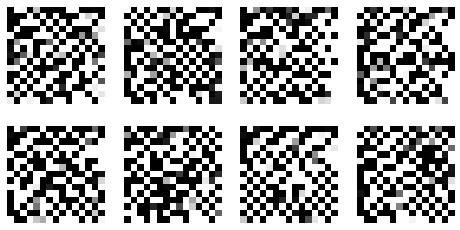

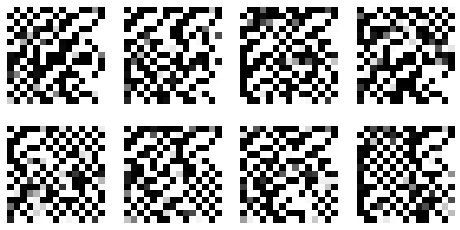

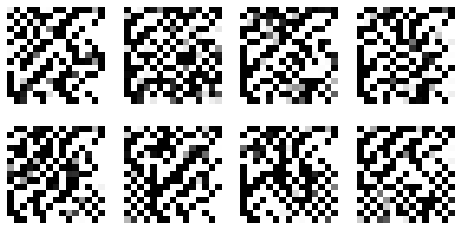

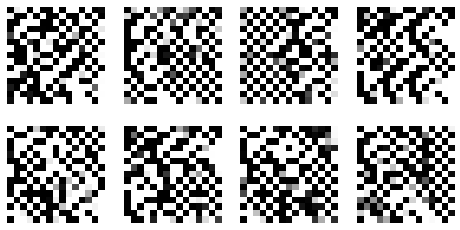

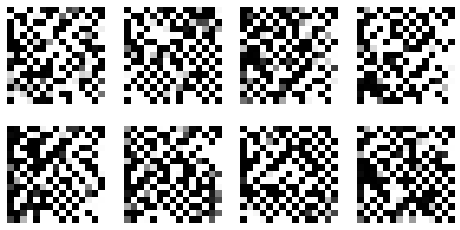

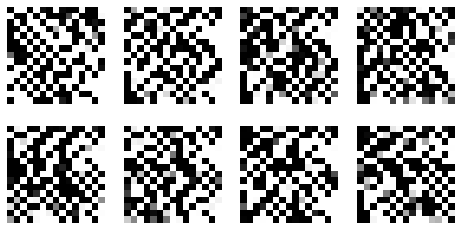

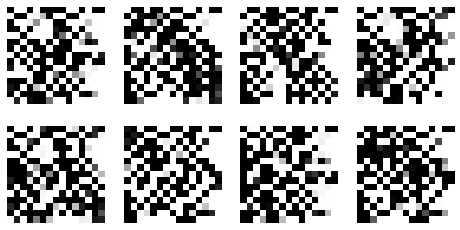

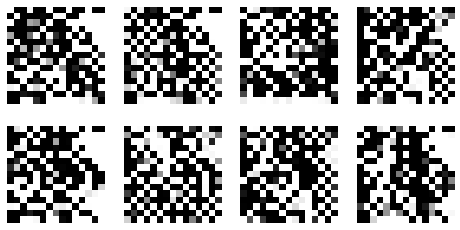

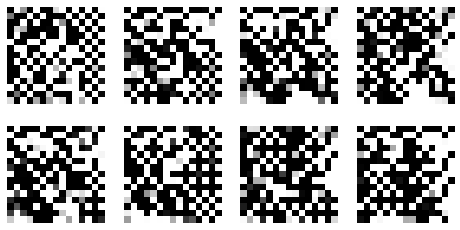

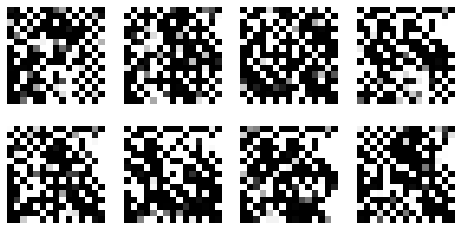

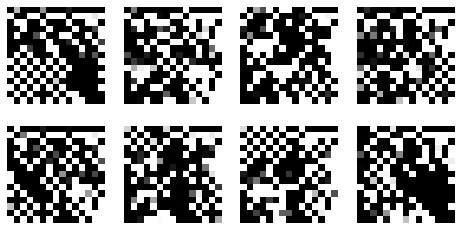

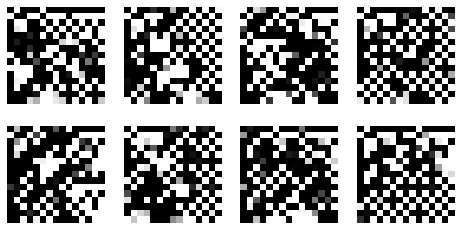

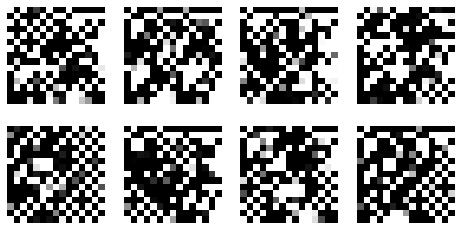

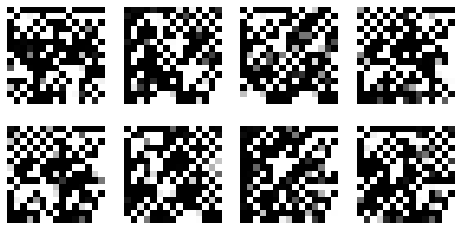

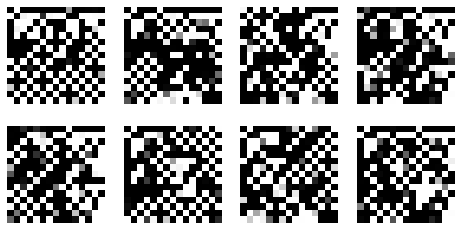

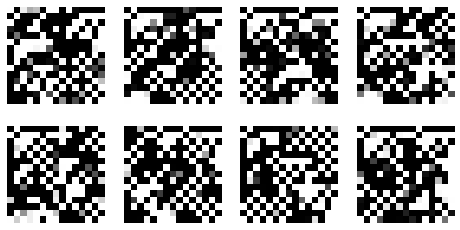

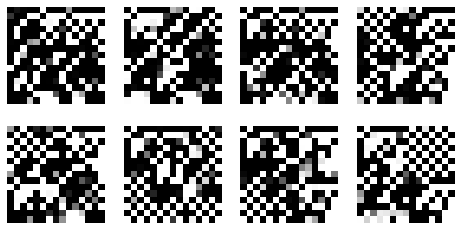

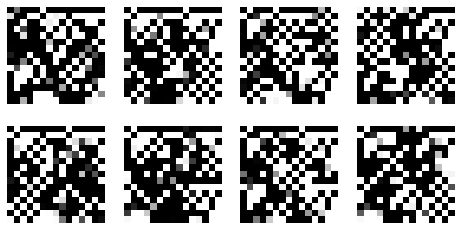

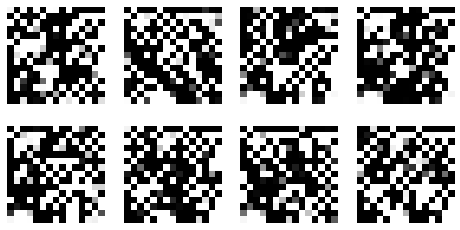

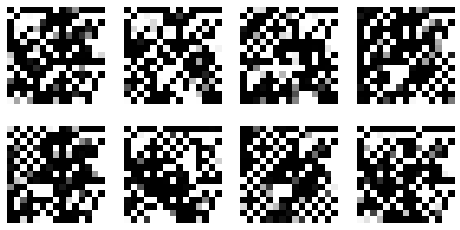

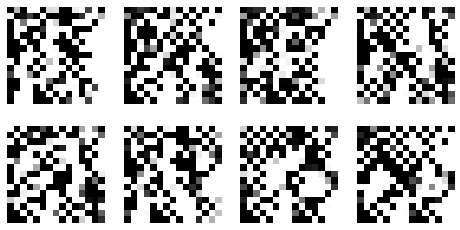

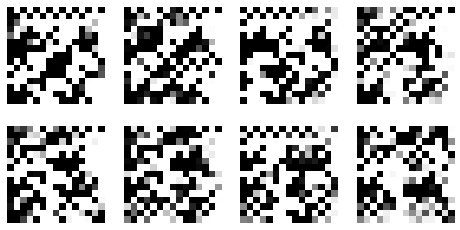

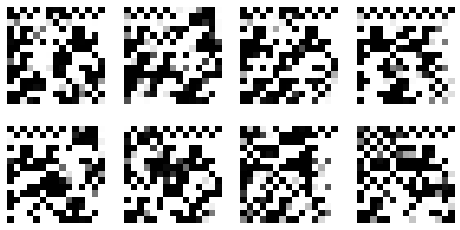

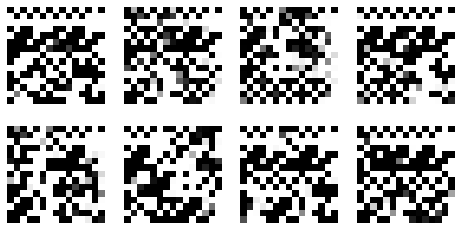

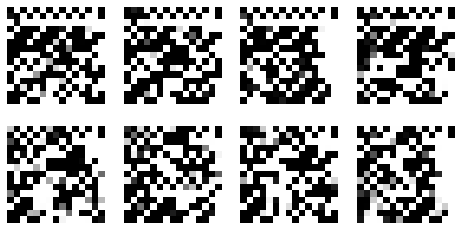

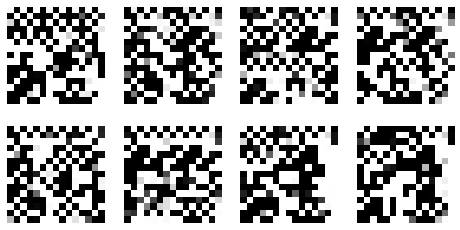

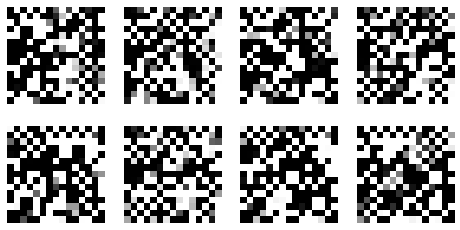

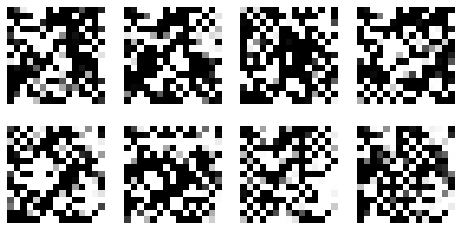

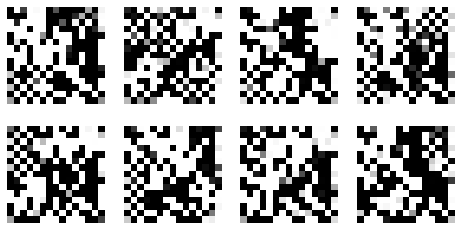

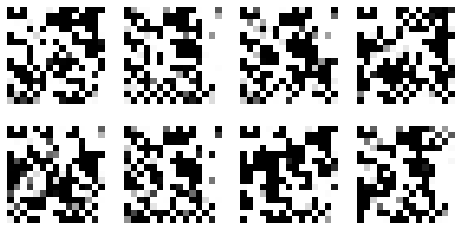

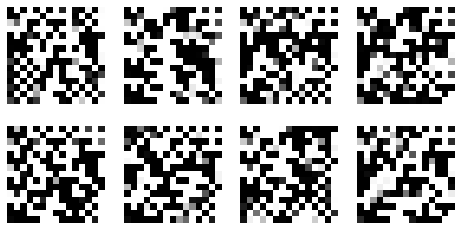

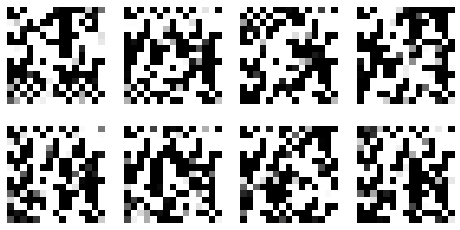

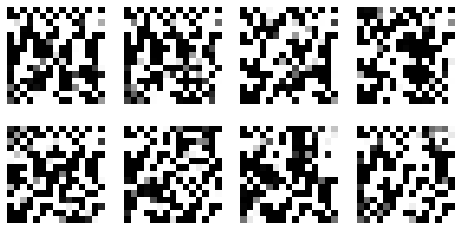

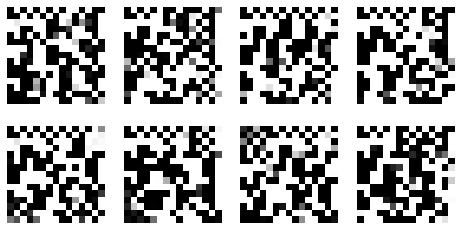

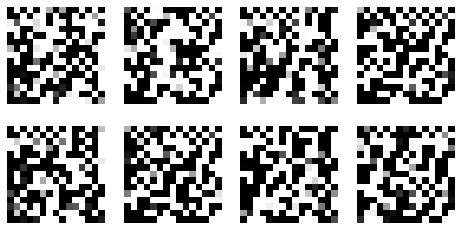

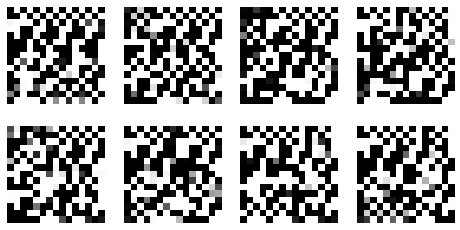

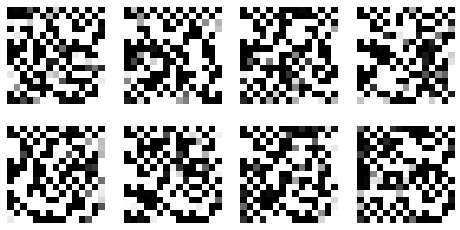

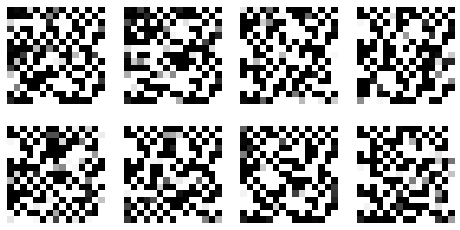

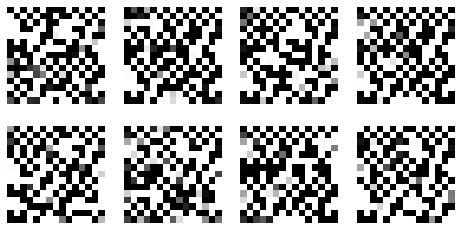

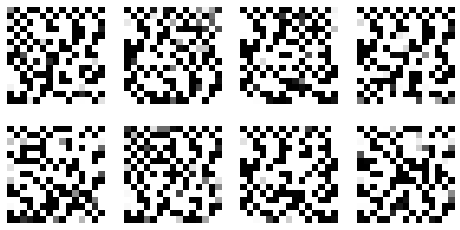

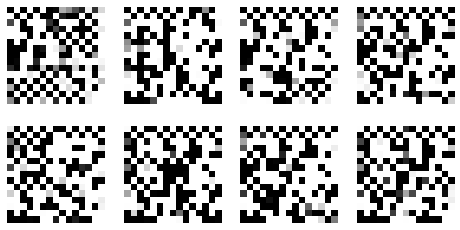

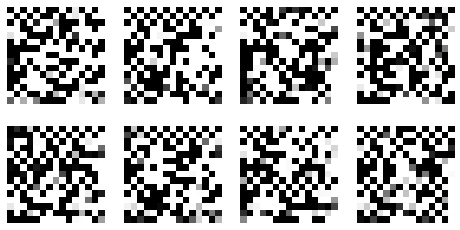

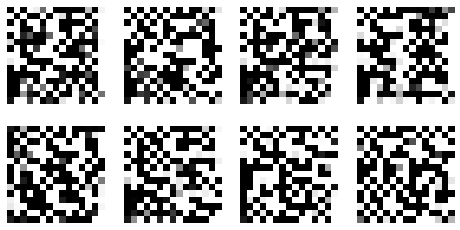

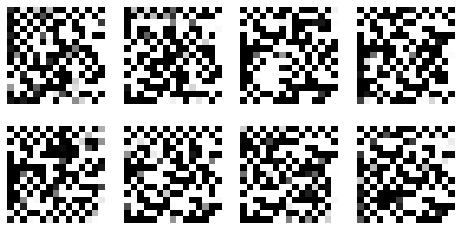

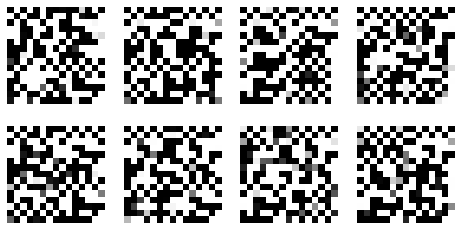

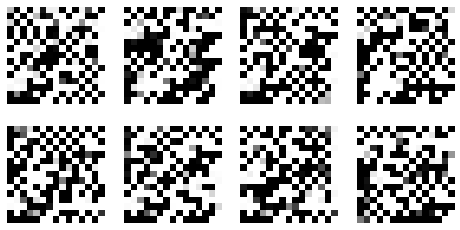

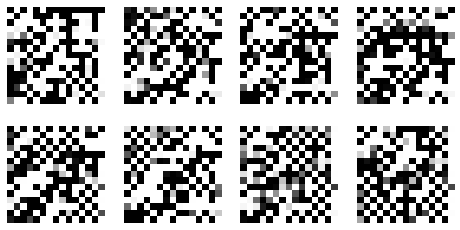

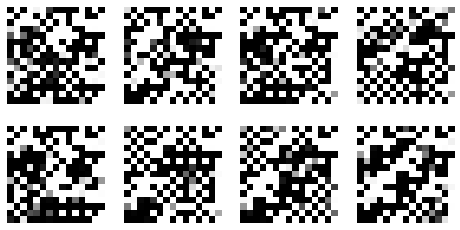

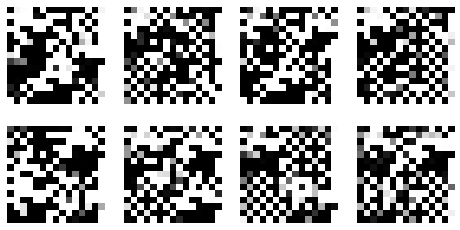

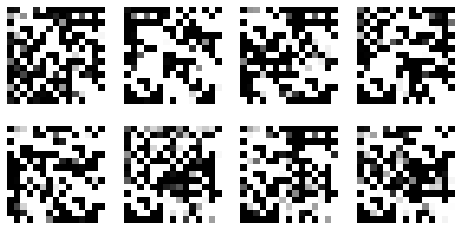

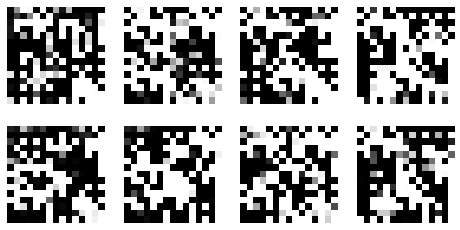

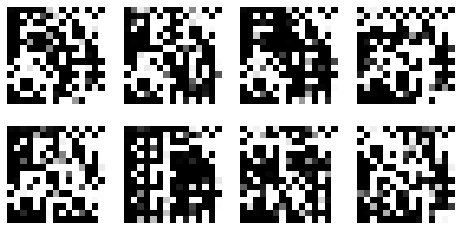

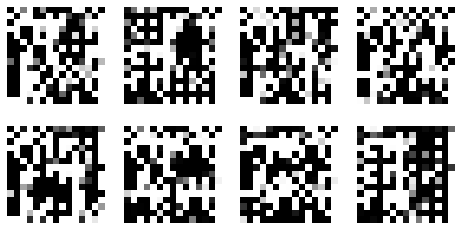

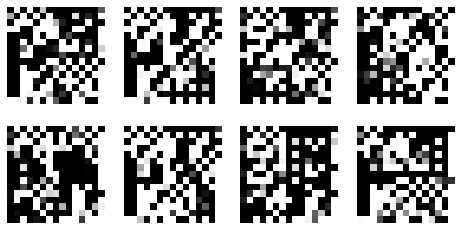

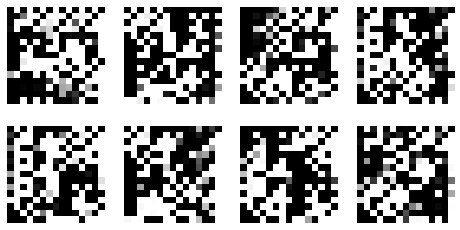

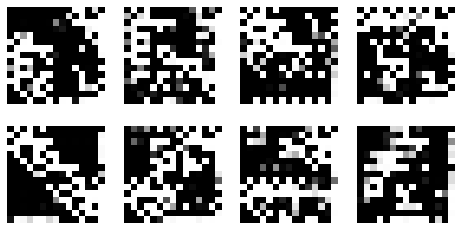

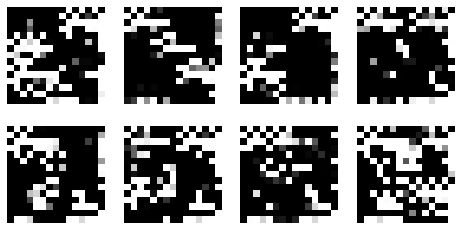

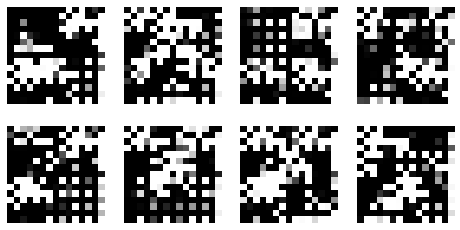

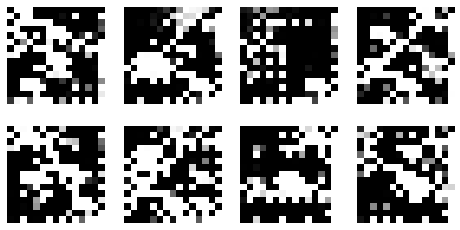

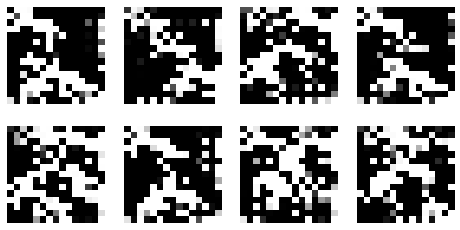

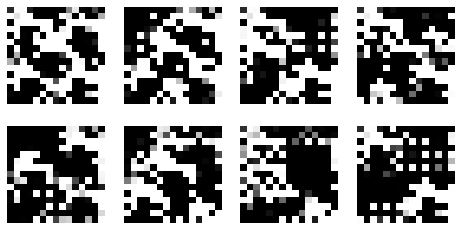

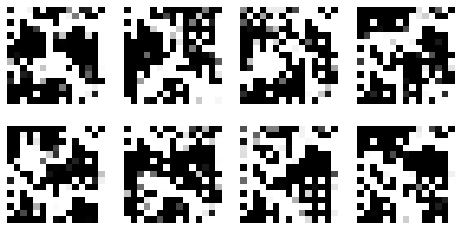

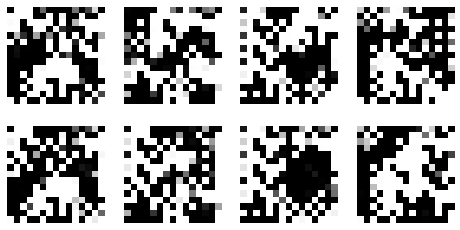

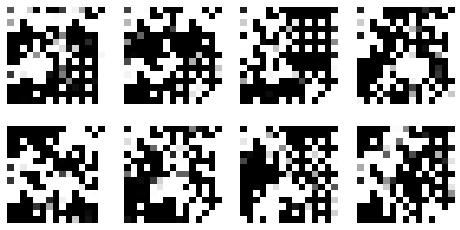

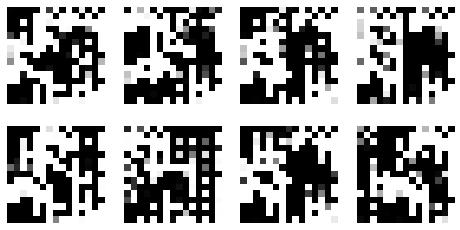

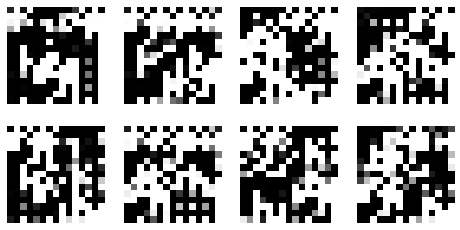

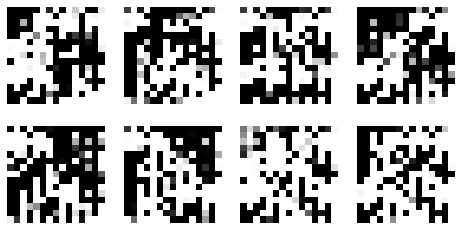

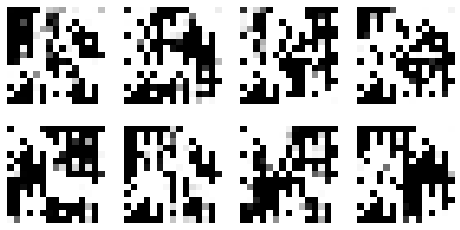

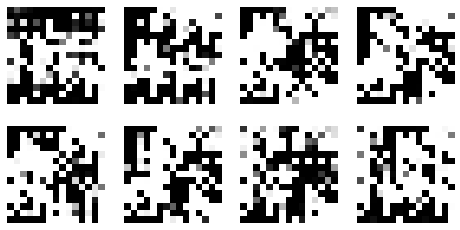

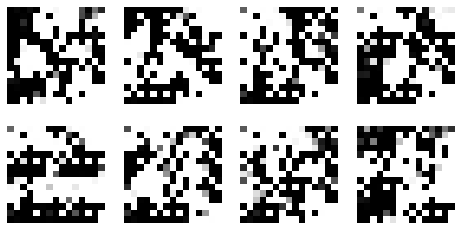

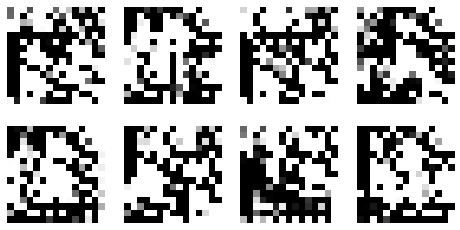

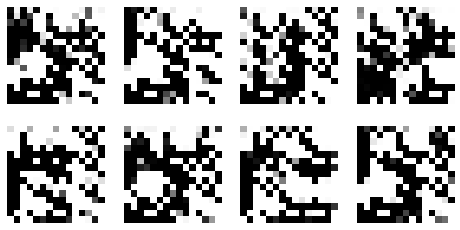

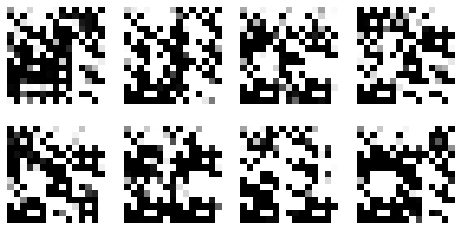

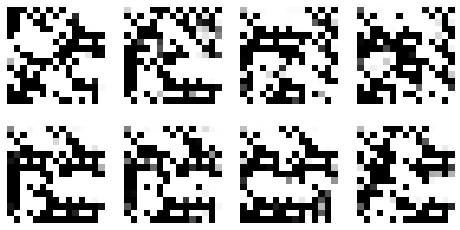

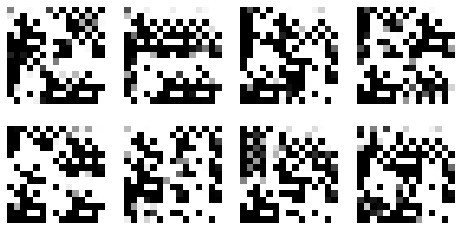

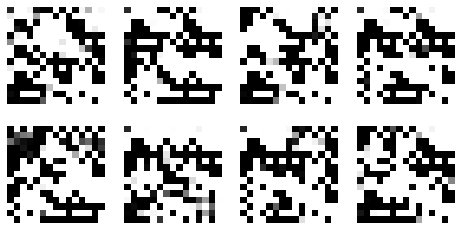

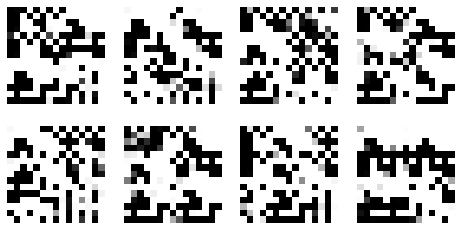

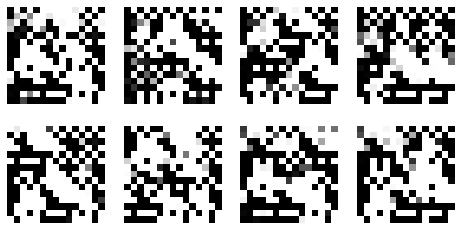

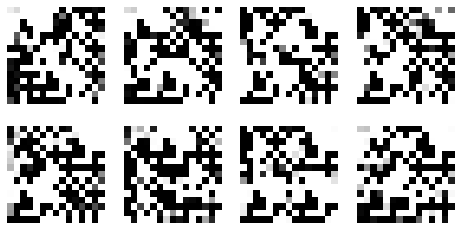

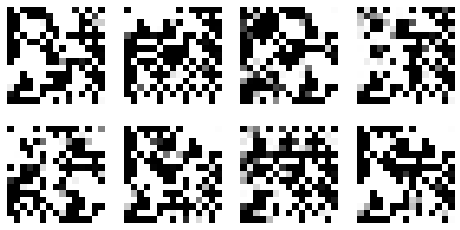

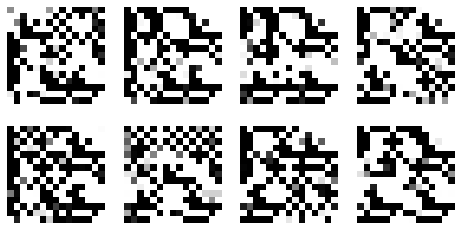

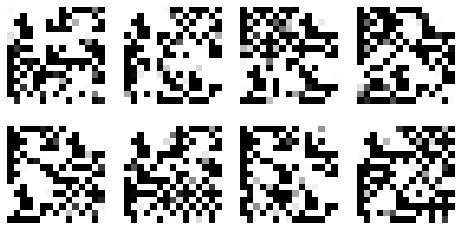

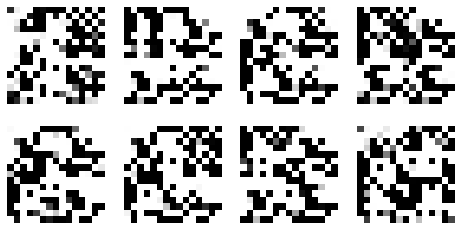

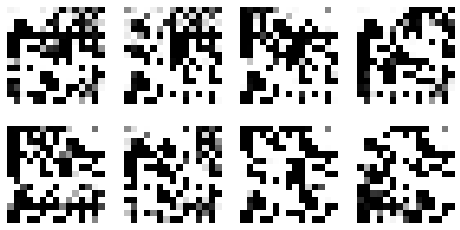

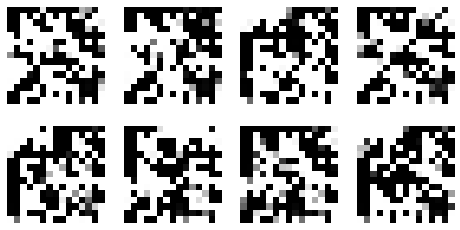

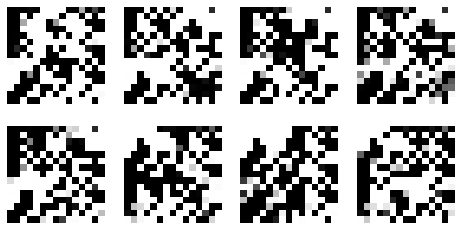

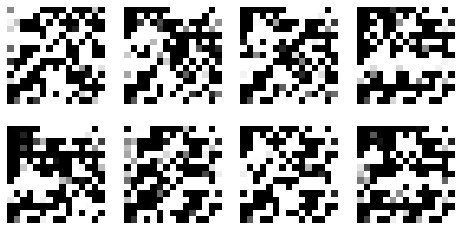

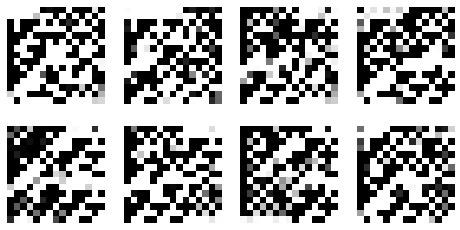

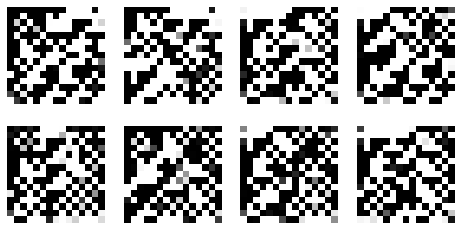

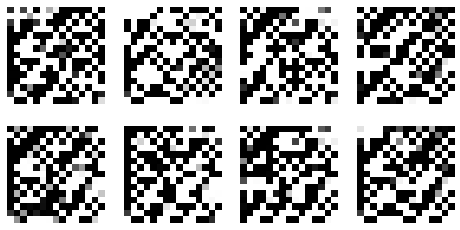

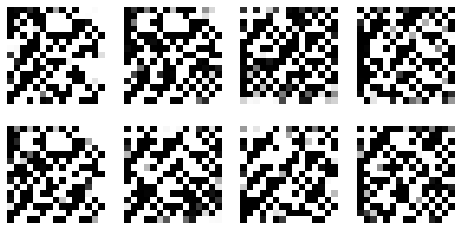

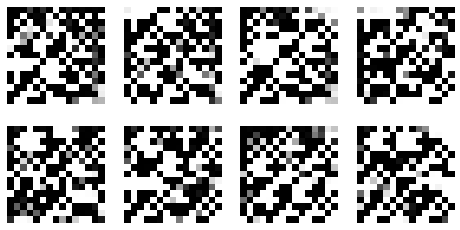

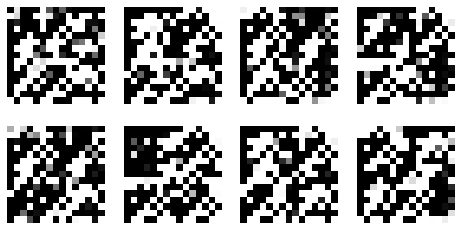

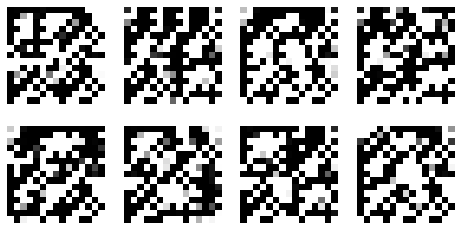

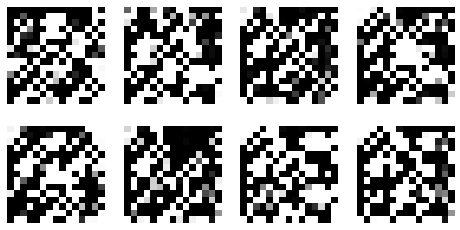

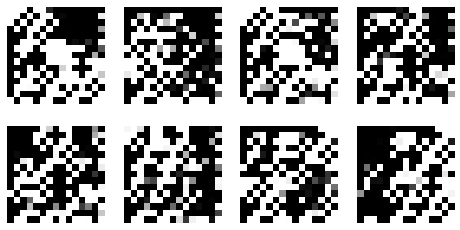

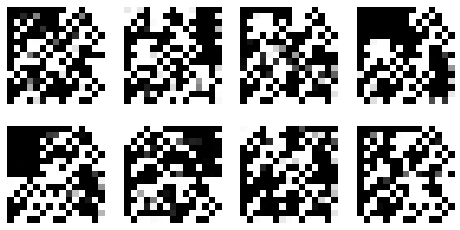

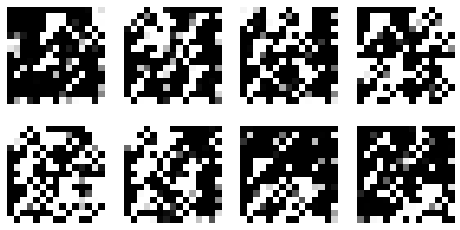

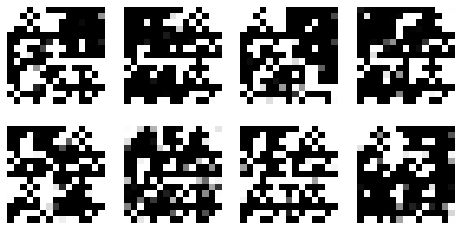

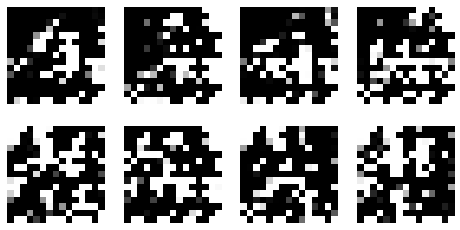

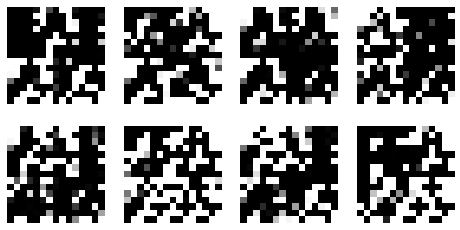

In [347]:
# Set hyperparameters
iterations = 20001
batch_size = 64
sample_interval = 200

# Train the DCGAN for the specified number of iterations
train(target_data, iterations, batch_size, sample_interval)

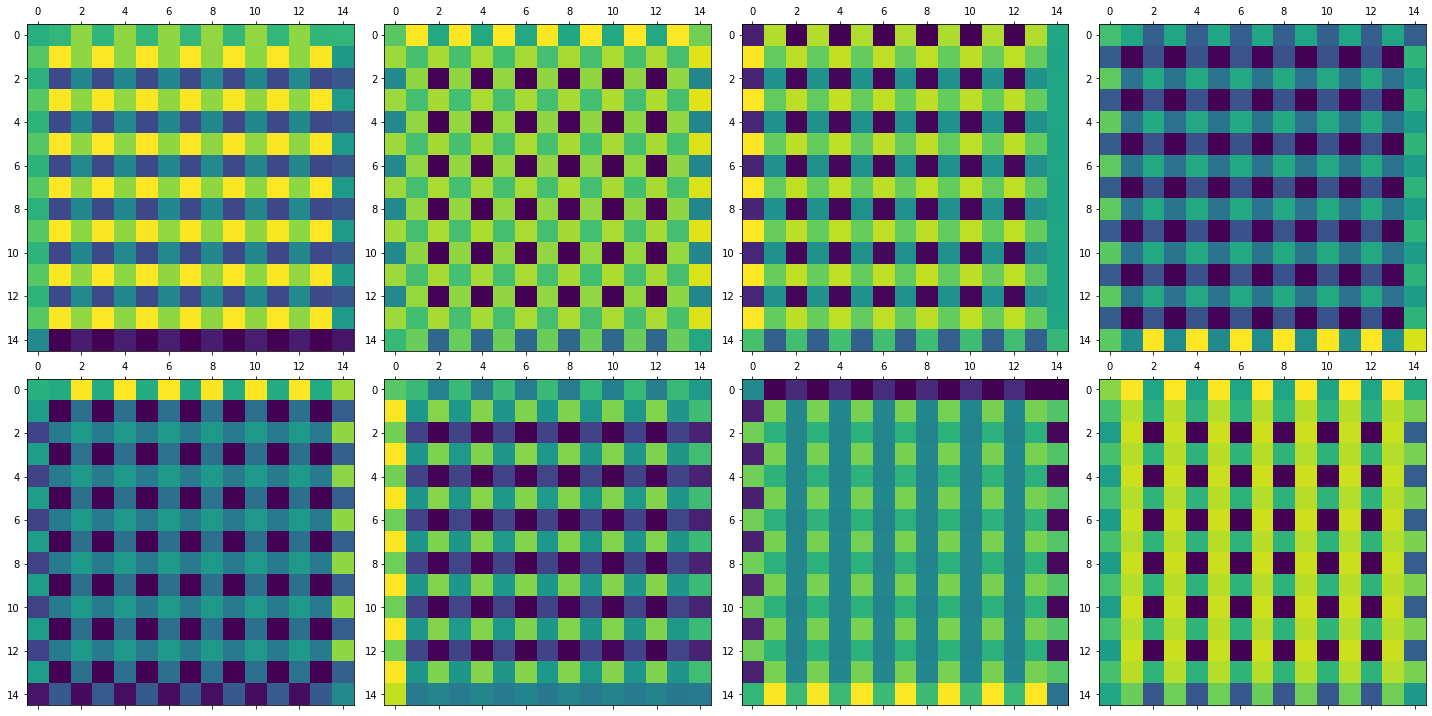

In [348]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(8):
    axs[i].matshow(generate_pattern('conv2d_43', i)[:,:,0])

fig.tight_layout()

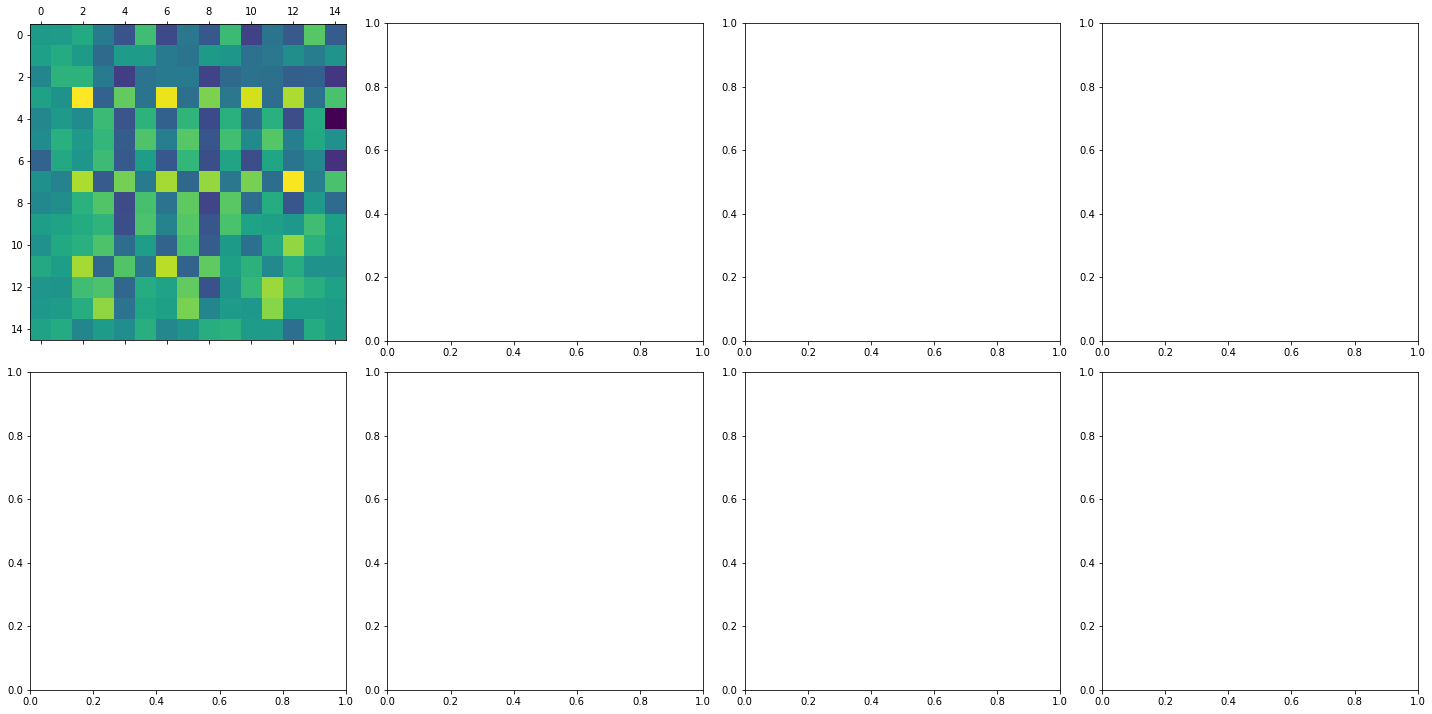

In [358]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(1):
    axs[i].matshow(generate_pattern('conv2d_44', i, size=15)[:,:,0])

fig.tight_layout()

## Visualize activations

In [375]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 7, 7, 8)           80        
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 3, 3, 1)           73        
_________________________________________________________________
batch_normalization_43 (Batc (None, 3, 3, 1)           4         
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 3, 3, 1)           0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 9)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 10        
Total para

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [376]:
discriminator.layers

In [379]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in discriminator.layers]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=discriminator.get_input_at(0), outputs=layer_outputs)

In [533]:
img = cfgs['a1'][1000]
img = img[np.newaxis, :, :, np.newaxis]

In [534]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img)

In [535]:
first_layer_activation = activations[4]
print(first_layer_activation.shape)

(1, 3, 3, 1)


In [536]:
# len(activations)
# first_layer_activation#[:, :]

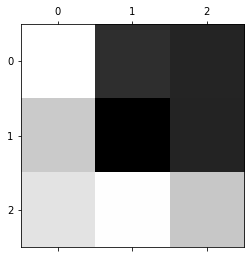

In [537]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='gray')

In [452]:
first_layer_activation[0, :, :, 0]

array([[2.473751 , 2.4667354, 2.4664547],
       [2.4719522, 2.4651978, 2.4663703],
       [2.4728   , 2.4736967, 2.471873 ]], dtype=float32)

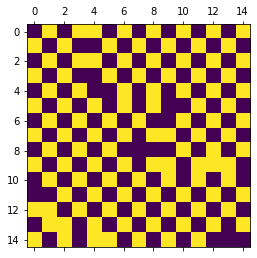

In [435]:
plt.matshow(img[0,:,:,0])